In [86]:
import pandas as pd
import numpy as np
import os

from tqdm import tqdm

import nibabel as nib

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import PIL

import sys
import torch
import torchvision
from torch import Tensor
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor
# from models import *

%load_ext autoreload
%autoreload 2

sys.path.insert(0,'/home/roshansk/Covid/CXRData/')
from SegLearner import *

import segmentation_models_pytorch as smp

sys.path.insert(0,'/home/roshansk/Covid/RibFrac/Models/')
from models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
from torchvision.transforms import Resize,ToTensor, RandomHorizontalFlip, RandomVerticalFlip,Normalize

import timm
import imgaug as ia
from imgaug import augmenters as iaa

In [88]:
trainFolder = '/home/roshansk/Covid/3dSeg/Liver/Data/OrigData/'
sliceFolder = '/home/roshansk/Covid/3dSeg/Liver/Data/Slices/'

dataFiles = os.listdir(trainFolder)

imgFiles = [x for x in dataFiles if 'orig' in x]

sliceList = sorted(os.listdir(sliceFolder))
imgFiles = [x for x in sliceList if 'image' in x]
labelFiles = [x.replace('image','label') for x in imgFiles]

df = pd.DataFrame({'imgPath':imgFiles,'maskPath':labelFiles})
df.imgPath = df.imgPath.apply(lambda x : os.path.join(sliceFolder, x))
df.maskPath = df.maskPath.apply(lambda x : os.path.join(sliceFolder, x))

def getAxis(x):
    
    if 'x' in x:
        return 'x'
    elif 'z' in x:
        return 'z'
    elif 'y' in x:
        return 'y'
    

df['axis'] = df.imgPath.apply(lambda x : getAxis(x))

df['patient'] = df.imgPath.apply(lambda x : x.split("/")[-1].split("_")[1])

print(len(df))

7837


In [89]:
0.8*len(df)

6269.6

In [79]:
df.head()

,imgPath,maskPath,axis,patient
0,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,x,e01
1,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,x,e01
2,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,x,e01
3,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,x,e01
4,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,/home/roshansk/Covid/3dSeg/Liver/Data/Slices/i...,x,e01


## Modeling

In [167]:
imgSize = 512

device = 'cuda:1'

batchSize = 10

In [168]:
class ImgAugTransform:
  def __init__(self ):
        
    self.aug = iaa.Sequential([
#         iaa.HorizontalFlip(p = 0.5),
#         iaa.VerticalFlip(p = 0.5),
#         iaa.Affine(scale=(0.5, 1.5)),
        iaa.Dropout(p=(0, 0.2), per_channel=0.5),
        iaa.SomeOf((1,2),[
#                     iaa.Cutout(fill_mode="gaussian", fill_per_channel=True),
                    iaa.SaltAndPepper(0.1),
#                     iaa.Affine(rotate=(-45, 45), shear=(-16, 16)),
#                     iaa.imgcorruptlike.GaussianNoise(severity=1),
#                     iaa.AveragePooling(2),
                    iaa.AddToHueAndSaturation((-60, 60)),
                    iaa.MultiplyBrightness(mul=(0.65, 1.35)),
                    iaa.LinearContrast((0.5, 2.0)),
                    iaa.GaussianBlur(sigma=(0.5, 2.0)),
#                     iaa.CoarseDropout((0.01,0.1), size_percent = 0.01)
        ])
    ])
    
    
      
  def __call__(self, img):
    img = np.array(img)
    return PIL.Image.fromarray(self.aug.augment_image(img))
 
    
    
imgTrainTransforms = transforms.Compose([Resize( (imgSize, imgSize) ),
                                      ImgAugTransform(),
                                       ToTensor(),
                                       Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                        ])

maskTrainTransforms = transforms.Compose([Resize( (imgSize, imgSize) ),
                                       ToTensor()])


imgTestTransforms = transforms.Compose([Resize( (imgSize, imgSize) ),
                                       ToTensor(),
                                       Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) ])

### Setup

In [169]:
# model = ResNetDUC(num_classes=1)

model = smp.Unet('resnet50', encoder_weights='imagenet', classes=1, activation='sigmoid')
# model = smp.PSPNet('resnet34', encoder_weights='imagenet')



criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
model.to(device)


trainTransforms = transforms.Compose([transforms.Resize((imgSize,imgSize)), 
                                      ToTensor()])


# trainTransforms = transforms.Compose([transforms.RandomResizedCrop(size = 256,scale = (0.06,0.5), ratio=(0.75, 1.3)), 
#                                       ToTensor()])

classLoss = nn.CrossEntropyLoss()
reconLoss = nn.MSELoss()

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


trainDataset = SegDataset(df.iloc[0:6270], imgTrainTransforms, maskTrainTransforms, preload=True, imgSize = imgSize)
testDataset = SegDataset(df.iloc[6270:len(df)], imgTestTransforms, maskTrainTransforms, preload =True, imgSize = imgSize)

# trainDataset = SegDataset(df.iloc[0:62], imgTrainTransforms, maskTrainTransforms, preload=True, imgSize = 256)
# testDataset = SegDataset(df.iloc[6270:len(df)], imgTestTransforms, maskTrainTransforms, preload =True, imgSize = 256)

trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, 
                                          shuffle=True, num_workers=6)


testLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, 
                                          shuffle=False, num_workers=6)

100%|██████████| 1567/1567 [00:10<00:00, 146.54it/s]


#### Checking Samples

In [28]:
img,mask = trainDataset[45]

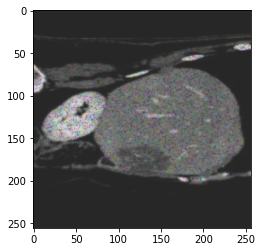

In [29]:
plt.imshow(img.permute(1,2,0).numpy())

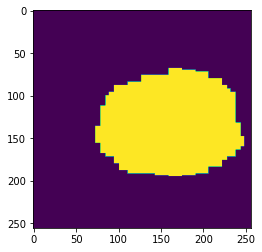

In [30]:
plt.imshow(mask.numpy())

### Training

In [170]:
learner = SegLearner(model, trainLoader, optimizer, criterion, testLoader, device = device)

In [171]:
learner.fit(num_epochs=3, save_best_model=False, save_every_epoch=False, useLogger = False)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch Time : 0:11:19.001974
Train Loss : 0.1861566154722962  Train IOU : 0.7596172094345093


  0%|          | 0/627 [00:00<?, ?it/s]

Test IOU : 0.61435866355896


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch Time : 0:11:21.753452
Train Loss : 0.0457987406779752  Train IOU : 0.03800638020038605


  0%|          | 0/627 [00:00<?, ?it/s]

Test IOU : 0.06847479194402695


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch Time : 0:11:22.393898
Train Loss : 0.029465323658674908  Train IOU : 0.8317543268203735


100%|██████████| 157/157 [00:44<00:00,  3.54it/s]

Test IOU : 0.6118060350418091


In [209]:
learner.optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00001),
])

learner.fit(num_epochs=2, save_best_model=False, save_every_epoch=False, useLogger = False)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch Time : 0:11:16.744346
Train Loss : 0.011066299285353466  Train IOU : 0.9171929359436035


  0%|          | 0/627 [00:00<?, ?it/s]

Test IOU : 0.6033183932304382


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch Time : 0:11:21.515289
Train Loss : 0.00989211462898569  Train IOU : 0.9281020760536194


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]

Test IOU : 0.6408423781394958


In [75]:
learner.optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00001),
])

learner.fit(num_epochs=2, save_best_model=False, save_every_epoch=False, useLogger = False)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch Time : 0:03:19.917093
Train Loss : 0.015124490492022113  Train IOU : 0.8675916790962219


  0%|          | 0/627 [00:00<?, ?it/s]

Test IOU : 0.3344607353210449


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch Time : 0:03:19.842932
Train Loss : 0.013702570508268366  Train IOU : 0.8751515746116638


100%|██████████| 157/157 [00:12<00:00, 12.54it/s]

Test IOU : 0.3449266254901886


In [ ]:
a = 1

### Using NPY files

In [11]:
trainX = '/home/roshansk/Covid/Live/Deep-Learning-liver-segmentation/imgs_train.npy'
testX = '/home/roshansk/Covid/Live/Deep-Learning-liver-segmentation/imgs_test.npy'

trainy = '/home/roshansk/Covid/Live/Deep-Learning-liver-segmentation/masks_train.npy'
testy = '/home/roshansk/Covid/Live/Deep-Learning-liver-segmentation/masks_test.npy'

In [12]:
trainX = np.load(trainX)
testX = np.load(testX)

trainy = np.load(trainy)
testy = np.load(testy)

In [70]:
class SegDataset2(torch.utils.data.Dataset):
    
  def __init__(self, matrix, mask):


    self.matrix = matrix
    self.mask = mask
    self.transforms = transforms


  def __len__(self):

    return self.matrix.shape[0]

  def __getitem__(self, index):
        
        
    img = self.matrix[index,:,:]
    mask = self.mask[index,:,:]
    
    img = Tensor(img).unsqueeze(0).repeat(3,1,1)
    mask = Tensor(mask).unsqueeze(0)
    
#     mask = mask.type(torch.uint8)

    return img, mask

In [71]:
trainDataset = SegDataset2(trainX, trainy)
testDataset = SegDataset2(testX, testy)

In [72]:
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, 
                                          shuffle=True, num_workers=1)


testLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, 
                                          shuffle=False, num_workers=1)

In [53]:
a = trainDataset[0][0]

In [62]:
a.unsqueeze(0).repeat(3,1,1).shape

torch.Size([3, 256, 256])

In [37]:
a[1].dtype

torch.float32

In [73]:
learner = SegLearner(model, trainLoader, optimizer, criterion, testLoader, device = 'cuda:0')

In [74]:
learner.fit(num_epochs=3, save_best_model=False, save_every_epoch=False, useLogger = False)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:23.890350
Train Loss : 0.6960874767426182  Train IOU : 0.309492290019989


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.2537856101989746


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:27.899459
Train Loss : 0.6619658693671227  Train IOU : 0.5513613224029541


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.35437560081481934


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.421801
Train Loss : 0.6582859603359419  Train IOU : 0.580426812171936


100%|██████████| 204/204 [00:47<00:00,  4.31it/s]


Test IOU : 0.3651917278766632


In [75]:
learner.fit(num_epochs=3, save_best_model=False, save_every_epoch=False, useLogger = False)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:24.470512
Train Loss : 0.6563309336848119  Train IOU : 0.6831493973731995


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.4163225293159485


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.303623
Train Loss : 0.6551946469527834  Train IOU : 0.6875644326210022


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.45044249296188354


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.197490
Train Loss : 0.6542562193730298  Train IOU : 0.7507726550102234


100%|██████████| 204/204 [00:47<00:00,  4.31it/s]

Test IOU : 0.44316619634628296


In [77]:
learner.fit(num_epochs=8, save_best_model=False, save_every_epoch=False, useLogger = False)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:23.707304
Train Loss : 0.6510335700038601  Train IOU : 0.8704193830490112


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.45024585723876953


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.368771
Train Loss : 0.6509412632269018  Train IOU : 0.8578366637229919


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.44591936469078064


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.423233
Train Loss : 0.6506421730360564  Train IOU : 0.8682854771614075


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.44542771577835083


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.534365
Train Loss : 0.6505153851912302  Train IOU : 0.8940397500991821


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.45929205417633057


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.514696
Train Loss : 0.6504148880348486  Train IOU : 0.8957321643829346


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.4533923268318176


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.445800
Train Loss : 0.6502281506271923  Train IOU : 0.9022810459136963


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.4574238061904907


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.303801
Train Loss : 0.6500961554839331  Train IOU : 0.9001471996307373


  0%|          | 0/272 [00:00<?, ?it/s]

Test IOU : 0.44660767912864685


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch Time : 0:04:28.158554
Train Loss : 0.649992504321477  Train IOU : 0.8989697694778442


100%|██████████| 204/204 [00:47<00:00,  4.31it/s]

Test IOU : 0.44739434123039246


In [ ]:
learner.fit(num_epochs=8, save_best_model=False, save_every_epoch=False, useLogger = False)

## Testing

In [108]:
trainDf = df.iloc[0:6270]
testDf = df.iloc[6270:]

In [113]:
index = 10
img = Image.open(testDf.iloc[index]['imgPath'])
mask = Image.open(testDf.iloc[index]['maskPath'])

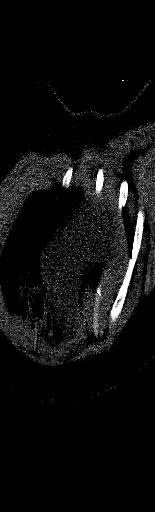

In [112]:
img

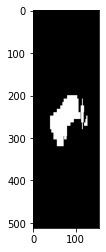

In [107]:
plt.imshow(np.array(mask)*255)

### Testing specific samples

In [189]:
def testSample(df, index, model, imgSize = 512, returnOutput = False, plot = True):
    
    testDataset = SegDataset(df.iloc[index:index+1], imgTestTransforms, maskTrainTransforms, preload =True, imgSize = imgSize)
    
    img,mask = testDataset[0]

    img = img.to(device)
    img = img.unsqueeze(0)

    out = model(img)
    out = out.detach().cpu().numpy()[0,0,:,:]

    if plot:
        plt.figure(figsize = (10,5))
        plt.subplot(121)
        plt.imshow(out)

        plt.subplot(122)
        plt.imshow(mask.cpu().numpy())
    
    pred_ = out>0.5
    pred_ = pred_.astype('int')
    
    diceScore = dice(pred_, mask.cpu().numpy() )
    
    print(diceScore)
    
    if returnOutput:
        return out, mask.cpu().numpy(), diceScore
    

100%|██████████| 1/1 [00:00<00:00, 78.32it/s]


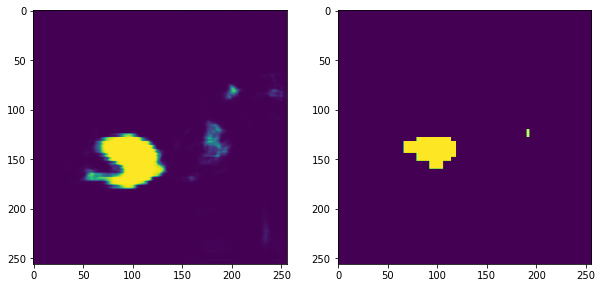

In [147]:
testSample(testDf, 5, learner.model)

100%|██████████| 1/1 [00:00<00:00, 79.78it/s]


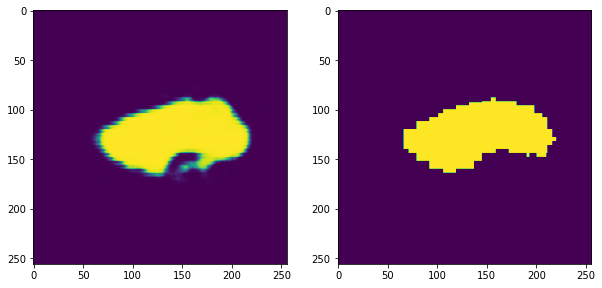

In [148]:
testSample(testDf, 15, learner.model)

100%|██████████| 1/1 [00:00<00:00, 63.06it/s]


0.9476600153146255


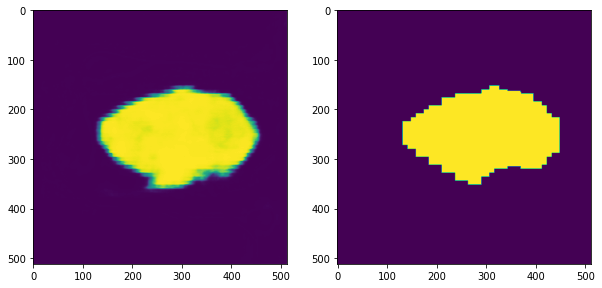

In [188]:
testSample(testDf, 25, learner.model)

100%|██████████| 1/1 [00:00<00:00, 64.40it/s]


0.8172836133497245


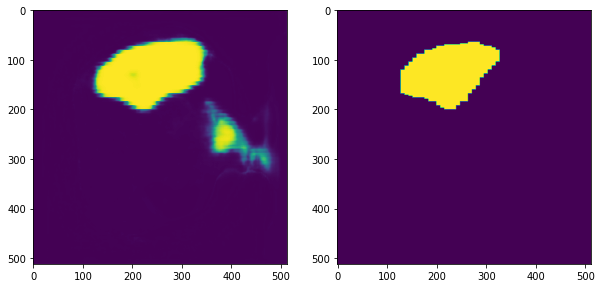

In [187]:
testSample(testDf, 125, learner.model)

100%|██████████| 1/1 [00:00<00:00, 62.77it/s]


0.9357436242545193


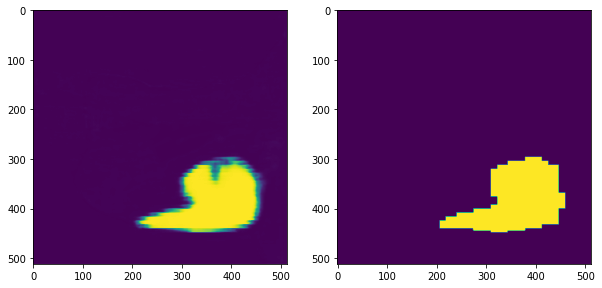

In [186]:
testSample(testDf, 325, learner.model)

100%|██████████| 1/1 [00:00<00:00, 65.32it/s]


0.9476600153146255


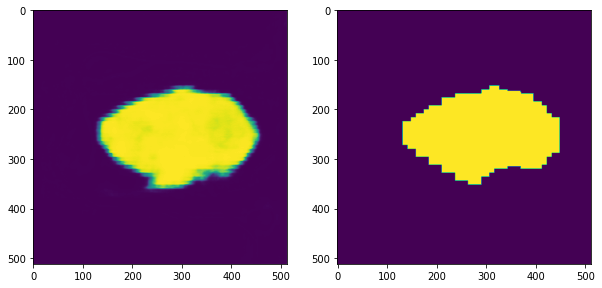

In [185]:
pred, mask, diceScore = testSample(testDf, 25, learner.model, returnOutput=True)

In [190]:
diceScoreList = []

for i in tqdm(range(len(testDf))):
    
    _,_,diceScore = testSample(testDf, i, learner.model, returnOutput = True, plot = False)
    diceScoreList.append(diceScore)
    

100%|██████████| 1/1 [00:00<00:00, 56.83it/s]

100%|██████████| 1/1 [00:00<00:00, 93.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.1317717874901858
0.1916052766832277
0.2339982137540935
0.30088994483147424


100%|██████████| 1/1 [00:00<00:00, 93.43it/s]

100%|██████████| 1/1 [00:00<00:00, 92.68it/s]

100%|██████████| 1/1 [00:00<00:00, 92.93it/s]

0.32915879017013233
0.3580888770824637
0.4327633189842423
0.5139155871291267




100%|██████████| 1/1 [00:00<00:00, 92.46it/s]

100%|██████████| 1/1 [00:00<00:00, 95.88it/s]

0.5083146597476117
0.647935944766745
0.699866065992938
0.8171317380144075




100%|██████████| 1/1 [00:00<00:00, 134.97it/s]

100%|██████████| 1/1 [00:00<00:00, 132.99it/s]

0.8291471258828109
0.8586825522537103
0.8955528009373249
0.9341687714526261




100%|██████████| 1/1 [00:00<00:00, 136.81it/s]

100%|██████████| 1/1 [00:00<00:00, 134.71it/s]

0.910119326688949
0.9381791374861777
0.9400014087483272
0.9379495798319327




100%|██████████| 1/1 [00:00<00:00, 134.00it/s]

100%|██████████| 1/1 [00:00<00:00, 133.12it/s]

0.92057632159155
0.9297550703201384
0.9353935320475355
0.9405533222984157




100%|██████████| 1/1 [00:00<00:00, 132.88it/s]

100%|██████████| 1/1 [00:00<00:00, 136.37it/s]

0.931413763317017
0.9476600153146255
0.9547180315092134
0.9481117726304811




100%|██████████| 1/1 [00:00<00:00, 131.85it/s]

100%|██████████| 1/1 [00:00<00:00, 132.98it/s]

0.9591716167008604
0.9607062676919406
0.9607150670375347
0.9642341521354044




100%|██████████| 1/1 [00:00<00:00, 132.86it/s]

100%|██████████| 1/1 [00:00<00:00, 126.41it/s]

0.9690637665220667
0.9724610491888801
0.9705732573117517
0.9645486398173301




100%|██████████| 1/1 [00:00<00:00, 131.93it/s]

100%|██████████| 1/1 [00:00<00:00, 135.96it/s]

0.972972972972973
0.9755776835485254
0.9746930640946095
0.974061067121108




100%|██████████| 1/1 [00:00<00:00, 132.98it/s]

100%|██████████| 1/1 [00:00<00:00, 131.26it/s]

0.9142543558787214
0.9477757676686595
0.9263216108192354
0.949666940638149




100%|██████████| 1/1 [00:00<00:00, 126.95it/s]

100%|██████████| 1/1 [00:00<00:00, 133.19it/s]

0.9591979033925608
0.9560922194317817
0.9364182351272108
0.953450254056712




100%|██████████| 1/1 [00:00<00:00, 133.63it/s]

100%|██████████| 1/1 [00:00<00:00, 117.21it/s]

0.9709554229390263
0.9777513606750347
0.9742795237984297
0.9620211898940505




100%|██████████| 1/1 [00:00<00:00, 54.17it/s]

  4%|▎         | 56/1567 [00:03<01:29, 16.89it/s]

0.9755743084857009
0.9742191081904
0.9717607586383653
0.965795926825618



100%|██████████| 1/1 [00:00<00:00, 87.33it/s]

100%|██████████| 1/1 [00:00<00:00, 91.64it/s]

100%|██████████| 1/1 [00:00<00:00, 94.08it/s]

0.9621744261994523
0.9640439158279963
0.9663325917941427
0.9644595525540108




100%|██████████| 1/1 [00:00<00:00, 91.86it/s]

100%|██████████| 1/1 [00:00<00:00, 91.87it/s]

0.9475514793030494
0.9586128840297305
0.9694071995288085
0.9705193552830969




100%|██████████| 1/1 [00:00<00:00, 93.71it/s]

100%|██████████| 1/1 [00:00<00:00, 104.92it/s]

0.9748870780511912
0.9683848321093714
0.9689110749941955
0.970956686512346




100%|██████████| 1/1 [00:00<00:00, 133.67it/s]

100%|██████████| 1/1 [00:00<00:00, 134.52it/s]

0.9708646284090507
0.9705864690551399
0.9668572547963319
0.9512494366267715




100%|██████████| 1/1 [00:00<00:00, 134.96it/s]

100%|██████████| 1/1 [00:00<00:00, 131.63it/s]

0.945114990444185
0.9636501431538764
0.9517480585653335
0.9473190558074097




100%|██████████| 1/1 [00:00<00:00, 133.56it/s]

100%|██████████| 1/1 [00:00<00:00, 136.68it/s]

0.8989625879690886
0.9014469125738741
0.8823794705272178
0.8225706524329219




100%|██████████| 1/1 [00:00<00:00, 55.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.8758169934640523
0.8679936415785472
0.6875
0.5881431538802057


100%|██████████| 1/1 [00:00<00:00, 94.37it/s]

100%|██████████| 1/1 [00:00<00:00, 98.52it/s]

100%|██████████| 1/1 [00:00<00:00, 97.00it/s]

0.5035289304101742
0.4008284840714074
0.3873502708476387
0.2796908450959759




100%|██████████| 1/1 [00:00<00:00, 97.35it/s]

100%|██████████| 1/1 [00:00<00:00, 96.65it/s]

0.22489007837889505
0.15042406785085613
0.1006013705654748
0.007380073800738007




100%|██████████| 1/1 [00:00<00:00, 97.27it/s]

100%|██████████| 1/1 [00:00<00:00, 102.55it/s]

0.008554720133667502
0.02451056758581295
0.04273806841952821
0.07931652779242696




100%|██████████| 1/1 [00:00<00:00, 135.81it/s]

100%|██████████| 1/1 [00:00<00:00, 122.30it/s]

0.10221270521056389
0.14854658659691264
0.22577760111298817
0.24236164902315174




100%|██████████| 1/1 [00:00<00:00, 130.91it/s]

100%|██████████| 1/1 [00:00<00:00, 131.68it/s]

0.3061986557132188
0.4742874287428743
0.45280591735005626
0.398626293085396




100%|██████████| 1/1 [00:00<00:00, 122.41it/s]

100%|██████████| 1/1 [00:00<00:00, 54.64it/s]

0.5991833957128275
0.5907004589902215
0.6819221967963387
0.6667873958710612




100%|██████████| 1/1 [00:00<00:00, 93.52it/s]

100%|██████████| 1/1 [00:00<00:00, 93.03it/s]

0.7091693731369845
0.9008954008954009
0.8820493746803664
0.8326825860013974




100%|██████████| 1/1 [00:00<00:00, 91.88it/s]

100%|██████████| 1/1 [00:00<00:00, 95.83it/s]

0.8394010910357101
0.8233172209797273
0.7831757847238233
0.8447272976117156




100%|██████████| 1/1 [00:00<00:00, 93.42it/s]

100%|██████████| 1/1 [00:00<00:00, 93.57it/s]

0.7397590361445783
0.750353312827334
0.8801920918049145
0.78216160055412




100%|██████████| 1/1 [00:00<00:00, 77.60it/s]

100%|██████████| 1/1 [00:00<00:00, 93.06it/s]

0.7383230163196398
0.735621301775148
0.7429537252752273



100%|██████████| 1/1 [00:00<00:00, 91.57it/s]

100%|██████████| 1/1 [00:00<00:00, 93.11it/s]

100%|██████████| 1/1 [00:00<00:00, 94.96it/s]

0.6974272005294507
0.7958570452993399
0.8172836133497245
0.8713251163013764



100%|██████████| 1/1 [00:00<00:00, 90.49it/s]

100%|██████████| 1/1 [00:00<00:00, 92.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.7839950114321347
0.8236698499317872
0.7417506045431177
0.8519040902679831


100%|██████████| 1/1 [00:00<00:00, 94.92it/s]

100%|██████████| 1/1 [00:00<00:00, 92.37it/s]

100%|██████████| 1/1 [00:00<00:00, 93.58it/s]

0.854957058283999
0.8668680438704969
0.8634853221652018
0.8641814739016507



100%|██████████| 1/1 [00:00<00:00, 92.12it/s]

100%|██████████| 1/1 [00:00<00:00, 93.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.8707962578358707
0.8782825163306942
0.8787674845844626
0.8788224799286352


100%|██████████| 1/1 [00:00<00:00, 75.33it/s]

100%|██████████| 1/1 [00:00<00:00, 93.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.9034392656565485
0.9132058093060741
0.9110350039393501
0.9444867166377957


100%|██████████| 1/1 [00:00<00:00, 91.78it/s]

100%|██████████| 1/1 [00:00<00:00, 92.32it/s]

100%|██████████| 1/1 [00:00<00:00, 94.42it/s]

0.9366413778962477
0.9325345222614403
0.8624099828808308
0.9220259473722788



100%|██████████| 1/1 [00:00<00:00, 90.68it/s]

100%|██████████| 1/1 [00:00<00:00, 92.56it/s]

100%|██████████| 1/1 [00:00<00:00, 94.96it/s]

0.8544911287976943
0.8909965304290748
0.9034079558923411
0.912569007574785



100%|██████████| 1/1 [00:00<00:00, 97.37it/s]

100%|██████████| 1/1 [00:00<00:00, 129.26it/s]

100%|██████████| 1/1 [00:00<00:00, 135.66it/s]

0.9042716927812682
0.9432521617650601
0.959909697586147
0.9619152802023585



100%|██████████| 1/1 [00:00<00:00, 132.74it/s]

100%|██████████| 1/1 [00:00<00:00, 131.92it/s]

100%|██████████| 1/1 [00:00<00:00, 135.01it/s]

0.9570996137921436
0.949510631117111
0.9500179791441927
0.9391562119527818



100%|██████████| 1/1 [00:00<00:00, 120.68it/s]

100%|██████████| 1/1 [00:00<00:00, 132.50it/s]

100%|██████████| 1/1 [00:00<00:00, 136.60it/s]

0.9363387837210502
0.9294678411970556
0.9367073616059532
0.9372822634048965



100%|██████████| 1/1 [00:00<00:00, 132.07it/s]

100%|██████████| 1/1 [00:00<00:00, 128.86it/s]

100%|██████████| 1/1 [00:00<00:00, 139.81it/s]

0.9346935315228756
0.9338731944148468
0.9335960913235374
0.9306896861793004



100%|██████████| 1/1 [00:00<00:00, 133.44it/s]

100%|██████████| 1/1 [00:00<00:00, 130.57it/s]

100%|██████████| 1/1 [00:00<00:00, 132.87it/s]

0.943479931533168
0.916878211603496
0.9232067070201071
0.9255064988830719



100%|██████████| 1/1 [00:00<00:00, 121.55it/s]

100%|██████████| 1/1 [00:00<00:00, 136.44it/s]

100%|██████████| 1/1 [00:00<00:00, 123.42it/s]

0.9169133337922489
0.9243534096820132
0.9258612613379892
0.9250491598518031



100%|██████████| 1/1 [00:00<00:00, 132.63it/s]

100%|██████████| 1/1 [00:00<00:00, 133.75it/s]

100%|██████████| 1/1 [00:00<00:00, 137.22it/s]

0.9222839682353139
0.9208417334510738
0.9169288283251417
0.9162959967650627



100%|██████████| 1/1 [00:00<00:00, 135.57it/s]

100%|██████████| 1/1 [00:00<00:00, 135.91it/s]

100%|██████████| 1/1 [00:00<00:00, 129.50it/s]

0.9232509183968299
0.9244942523999835
0.9204410796576695
0.9172593548811472



100%|██████████| 1/1 [00:00<00:00, 134.25it/s]

100%|██████████| 1/1 [00:00<00:00, 139.82it/s]

100%|██████████| 1/1 [00:00<00:00, 135.46it/s]

0.9182298751333784
0.9149174656678144
0.9212921019506602
0.9222555835648111



100%|██████████| 1/1 [00:00<00:00, 116.91it/s]

100%|██████████| 1/1 [00:00<00:00, 130.55it/s]

100%|██████████| 1/1 [00:00<00:00, 137.06it/s]

0.9235772878749039
0.9203946522689291
0.920170342057842
0.9200462562369096



100%|██████████| 1/1 [00:00<00:00, 131.90it/s]

100%|██████████| 1/1 [00:00<00:00, 130.61it/s]

100%|██████████| 1/1 [00:00<00:00, 137.79it/s]

0.9253142875609992
0.921598701562183
0.9240458169749464
0.9319988367584335



100%|██████████| 1/1 [00:00<00:00, 134.48it/s]

100%|██████████| 1/1 [00:00<00:00, 131.44it/s]

100%|██████████| 1/1 [00:00<00:00, 137.73it/s]

0.9356062137618166
0.9342119126932024
0.9257646195253242
0.9246198109330045



100%|██████████| 1/1 [00:00<00:00, 131.71it/s]

100%|██████████| 1/1 [00:00<00:00, 131.04it/s]

100%|██████████| 1/1 [00:00<00:00, 134.81it/s]

0.9239510344713346
0.9212585344784624
0.921104176349512
0.9243127126223493



100%|██████████| 1/1 [00:00<00:00, 131.40it/s]

100%|██████████| 1/1 [00:00<00:00, 139.08it/s]

100%|██████████| 1/1 [00:00<00:00, 131.01it/s]

0.9223620425489162
0.9244576402712642
0.9324998527667236
0.9279453074762243



100%|██████████| 1/1 [00:00<00:00, 129.86it/s]

100%|██████████| 1/1 [00:00<00:00, 118.68it/s]

100%|██████████| 1/1 [00:00<00:00, 134.91it/s]

0.9077213133270198
0.9072126520940387
0.9144628136080669
0.9269069329859604



100%|██████████| 1/1 [00:00<00:00, 132.76it/s]

100%|██████████| 1/1 [00:00<00:00, 129.51it/s]

100%|██████████| 1/1 [00:00<00:00, 131.66it/s]

0.9284694131414303
0.9279554049869086
0.9382051645187178
0.9376377446297329



100%|██████████| 1/1 [00:00<00:00, 130.79it/s]

100%|██████████| 1/1 [00:00<00:00, 136.78it/s]

100%|██████████| 1/1 [00:00<00:00, 136.88it/s]

0.9457814080421382
0.94027105517909
0.913935003521481
0.9103747630983676



100%|██████████| 1/1 [00:00<00:00, 116.70it/s]

100%|██████████| 1/1 [00:00<00:00, 125.49it/s]

100%|██████████| 1/1 [00:00<00:00, 135.27it/s]

0.9119306834359221
0.9219359309866876
0.9253373561199396
0.9272391926057943



100%|██████████| 1/1 [00:00<00:00, 135.31it/s]

100%|██████████| 1/1 [00:00<00:00, 127.58it/s]

100%|██████████| 1/1 [00:00<00:00, 137.19it/s]

0.930965244571405
0.9293320027571733
0.9372213396197406
0.9392384663246259



100%|██████████| 1/1 [00:00<00:00, 137.95it/s]

100%|██████████| 1/1 [00:00<00:00, 121.65it/s]

100%|██████████| 1/1 [00:00<00:00, 123.35it/s]

0.9535152918240526
0.9622206025267249
0.9664829795593525
0.9648561651486074



100%|██████████| 1/1 [00:00<00:00, 119.80it/s]

100%|██████████| 1/1 [00:00<00:00, 121.14it/s]

100%|██████████| 1/1 [00:00<00:00, 137.90it/s]

0.9645347944083158
0.9627169903854996
0.9631794033510421
0.9677856622064306



100%|██████████| 1/1 [00:00<00:00, 140.37it/s]

100%|██████████| 1/1 [00:00<00:00, 135.52it/s]

100%|██████████| 1/1 [00:00<00:00, 134.40it/s]

0.9662378425258636
0.9666300722911532
0.9667058688841939
0.9656522288167698



100%|██████████| 1/1 [00:00<00:00, 130.15it/s]

100%|██████████| 1/1 [00:00<00:00, 126.82it/s]

100%|██████████| 1/1 [00:00<00:00, 137.89it/s]

0.9652293967714528
0.9653062970568104
0.9634120079248859
0.9595680260583471



100%|██████████| 1/1 [00:00<00:00, 134.12it/s]

100%|██████████| 1/1 [00:00<00:00, 134.74it/s]

100%|██████████| 1/1 [00:00<00:00, 136.94it/s]

0.9594499758761349
0.9620748769562573
0.9618385176117078
0.9546918278649762



100%|██████████| 1/1 [00:00<00:00, 136.32it/s]

100%|██████████| 1/1 [00:00<00:00, 132.68it/s]

100%|██████████| 1/1 [00:00<00:00, 133.90it/s]

0.958535358155704
0.9506608652819966
0.9471636952998379
0.9475048446622314



100%|██████████| 1/1 [00:00<00:00, 136.28it/s]

100%|██████████| 1/1 [00:00<00:00, 136.35it/s]

100%|██████████| 1/1 [00:00<00:00, 139.55it/s]

0.9428189287306541
0.9428171150212716
0.9328223565511701
0.9466242861476372



100%|██████████| 1/1 [00:00<00:00, 134.14it/s]

100%|██████████| 1/1 [00:00<00:00, 137.67it/s]

100%|██████████| 1/1 [00:00<00:00, 136.24it/s]

0.9483322604800252
0.944706782388477
0.9310523449640717
0.9304975417357126



100%|██████████| 1/1 [00:00<00:00, 137.71it/s]

100%|██████████| 1/1 [00:00<00:00, 130.46it/s]

100%|██████████| 1/1 [00:00<00:00, 136.18it/s]

0.9243050959629384
0.9213973799126638
0.903763823229999
0.9001897533206831



100%|██████████| 1/1 [00:00<00:00, 136.49it/s]

100%|██████████| 1/1 [00:00<00:00, 132.96it/s]

100%|██████████| 1/1 [00:00<00:00, 137.04it/s]

0.8975920600011278
0.8971004142265391
0.9015243164771353
0.9008181426725994



100%|██████████| 1/1 [00:00<00:00, 133.89it/s]

100%|██████████| 1/1 [00:00<00:00, 121.56it/s]

100%|██████████| 1/1 [00:00<00:00, 135.40it/s]

0.9034836743203025
0.8936164133043777
0.9072845780572544
0.9039133722340319



100%|██████████| 1/1 [00:00<00:00, 137.31it/s]

100%|██████████| 1/1 [00:00<00:00, 124.02it/s]

100%|██████████| 1/1 [00:00<00:00, 137.00it/s]

0.9107597289337489
0.9032876017691636
0.8882401292480372
0.8892252494674291



100%|██████████| 1/1 [00:00<00:00, 135.81it/s]

100%|██████████| 1/1 [00:00<00:00, 137.19it/s]

100%|██████████| 1/1 [00:00<00:00, 141.64it/s]

0.885123147203867
0.885840683342144
0.8896938960333273
0.8842031425364759



100%|██████████| 1/1 [00:00<00:00, 137.42it/s]

100%|██████████| 1/1 [00:00<00:00, 122.69it/s]

100%|██████████| 1/1 [00:00<00:00, 139.48it/s]

0.9069558629591178
0.9224939815672142
0.9336486886007518
0.9369422710932543



100%|██████████| 1/1 [00:00<00:00, 137.32it/s]

100%|██████████| 1/1 [00:00<00:00, 135.62it/s]

100%|██████████| 1/1 [00:00<00:00, 140.70it/s]

0.9426027280719167
0.9361044513128629
0.9484357470497181
0.9447205686875109



100%|██████████| 1/1 [00:00<00:00, 139.60it/s]

100%|██████████| 1/1 [00:00<00:00, 134.20it/s]

100%|██████████| 1/1 [00:00<00:00, 135.00it/s]

0.9601038042548338
0.9546653597220821
0.9456897804913504
0.9534264219431515



100%|██████████| 1/1 [00:00<00:00, 126.86it/s]

100%|██████████| 1/1 [00:00<00:00, 135.00it/s]

100%|██████████| 1/1 [00:00<00:00, 135.98it/s]

0.9488307954112021
0.9461507540680969
0.9436259771497294
0.9481861331135631



100%|██████████| 1/1 [00:00<00:00, 137.04it/s]

100%|██████████| 1/1 [00:00<00:00, 138.52it/s]

100%|██████████| 1/1 [00:00<00:00, 138.25it/s]

0.9364051849194341
0.9411025403358836
0.9330183030440341
0.8894062042572703



100%|██████████| 1/1 [00:00<00:00, 138.21it/s]

100%|██████████| 1/1 [00:00<00:00, 135.53it/s]

100%|██████████| 1/1 [00:00<00:00, 139.56it/s]

0.8807382189571762
0.8862479399377403
0.9018809065051839
0.9068185995221467



100%|██████████| 1/1 [00:00<00:00, 137.45it/s]

100%|██████████| 1/1 [00:00<00:00, 138.88it/s]

100%|██████████| 1/1 [00:00<00:00, 137.98it/s]

0.9210934250822337
0.8925513784461153
0.9405420085743661
0.9485080955292169



100%|██████████| 1/1 [00:00<00:00, 137.49it/s]

100%|██████████| 1/1 [00:00<00:00, 136.80it/s]

100%|██████████| 1/1 [00:00<00:00, 138.15it/s]

0.9434732053609678
0.9565949260550679
0.9519924060347787
0.9448261589403973



100%|██████████| 1/1 [00:00<00:00, 139.35it/s]

100%|██████████| 1/1 [00:00<00:00, 133.16it/s]

100%|██████████| 1/1 [00:00<00:00, 132.33it/s]

0.9246079099897716
0.9252713046073812
0.9547814436442806
0.9267348270611269



100%|██████████| 1/1 [00:00<00:00, 139.11it/s]

100%|██████████| 1/1 [00:00<00:00, 139.67it/s]

100%|██████████| 1/1 [00:00<00:00, 135.51it/s]

0.9295115658752022
0.9447842040887646
0.8864271042488864
0.9093572605749862



100%|██████████| 1/1 [00:00<00:00, 139.05it/s]

100%|██████████| 1/1 [00:00<00:00, 135.35it/s]

100%|██████████| 1/1 [00:00<00:00, 142.76it/s]

0.9294586997914589
0.9350379472352729
0.9219157530294287
0.9446159433448339



100%|██████████| 1/1 [00:00<00:00, 138.14it/s]

100%|██████████| 1/1 [00:00<00:00, 137.55it/s]

100%|██████████| 1/1 [00:00<00:00, 138.42it/s]

0.9403177913276062
0.9359694347265697
0.9357436242545193
0.9485079805690493



100%|██████████| 1/1 [00:00<00:00, 121.81it/s]

100%|██████████| 1/1 [00:00<00:00, 138.95it/s]

100%|██████████| 1/1 [00:00<00:00, 141.27it/s]

0.9449079468655325
0.9397045881597412
0.7493433824369076
0.8636615994712492



100%|██████████| 1/1 [00:00<00:00, 136.54it/s]

100%|██████████| 1/1 [00:00<00:00, 139.33it/s]

100%|██████████| 1/1 [00:00<00:00, 137.10it/s]

0.8362464496395019
0.9017925298096918
0.9349652525671611
0.9196884374506605



100%|██████████| 1/1 [00:00<00:00, 134.94it/s]

100%|██████████| 1/1 [00:00<00:00, 123.36it/s]

100%|██████████| 1/1 [00:00<00:00, 138.51it/s]

0.9359786420980998
0.9191073919107392
0.8721796028880866
0.8979683845698667



100%|██████████| 1/1 [00:00<00:00, 137.16it/s]

100%|██████████| 1/1 [00:00<00:00, 130.79it/s]

100%|██████████| 1/1 [00:00<00:00, 140.66it/s]

0.9116462470074638
0.902093258264761
0.9136464007066097
0.9234142150327378



100%|██████████| 1/1 [00:00<00:00, 141.33it/s]

100%|██████████| 1/1 [00:00<00:00, 138.58it/s]

100%|██████████| 1/1 [00:00<00:00, 139.29it/s]

0.9313133751810719
0.9381398791168126
0.9223409344602137
0.9180283864040533



100%|██████████| 1/1 [00:00<00:00, 135.19it/s]

100%|██████████| 1/1 [00:00<00:00, 130.53it/s]

100%|██████████| 1/1 [00:00<00:00, 142.76it/s]

0.9223894637817498
0.9021297293541326
0.9147260037316012
0.888362556561086



100%|██████████| 1/1 [00:00<00:00, 135.24it/s]

100%|██████████| 1/1 [00:00<00:00, 139.56it/s]

100%|██████████| 1/1 [00:00<00:00, 142.35it/s]

0.8706570857100526
0.8749040675364543
0.8304886778945783
0.8542665388302972



100%|██████████| 1/1 [00:00<00:00, 139.05it/s]

100%|██████████| 1/1 [00:00<00:00, 131.10it/s]

100%|██████████| 1/1 [00:00<00:00, 140.08it/s]

0.850356294536817
0.8727454492439705
0.8664997742848936
0.8585158409525835



100%|██████████| 1/1 [00:00<00:00, 134.83it/s]

100%|██████████| 1/1 [00:00<00:00, 140.20it/s]

100%|██████████| 1/1 [00:00<00:00, 141.05it/s]

0.8630172638153899
0.866707724793243
0.8673059360730594
0.8158599101755659



100%|██████████| 1/1 [00:00<00:00, 137.76it/s]

100%|██████████| 1/1 [00:00<00:00, 138.32it/s]

100%|██████████| 1/1 [00:00<00:00, 128.46it/s]

0.8470293306593131
0.8648372425775461
0.8384883352686583
0.8534839503411251



100%|██████████| 1/1 [00:00<00:00, 138.65it/s]

100%|██████████| 1/1 [00:00<00:00, 138.45it/s]

100%|██████████| 1/1 [00:00<00:00, 142.27it/s]

0.86708131766874
0.8456423652339112
0.8842199948599332
0.8161282487247996



100%|██████████| 1/1 [00:00<00:00, 141.01it/s]

100%|██████████| 1/1 [00:00<00:00, 140.88it/s]

100%|██████████| 1/1 [00:00<00:00, 145.26it/s]

0.8654905515654417
0.8165571801935438
0.7346486673589477
0.6964285714285714



100%|██████████| 1/1 [00:00<00:00, 140.02it/s]

100%|██████████| 1/1 [00:00<00:00, 137.93it/s]

100%|██████████| 1/1 [00:00<00:00, 142.57it/s]

0.7043241695303551
0.659943645261753
0.6639839034205232
0.5828298649958976



100%|██████████| 1/1 [00:00<00:00, 138.62it/s]

100%|██████████| 1/1 [00:00<00:00, 137.36it/s]

100%|██████████| 1/1 [00:00<00:00, 144.24it/s]

0.6198281349458943
0.5343795168284121
0.40006515719172503
0.4627558694656988



100%|██████████| 1/1 [00:00<00:00, 137.79it/s]

100%|██████████| 1/1 [00:00<00:00, 136.49it/s]

100%|██████████| 1/1 [00:00<00:00, 140.64it/s]

0.43946015424164525
0.42060247783158294
0.4330308296324902
0.38882817243472984



100%|██████████| 1/1 [00:00<00:00, 134.86it/s]

100%|██████████| 1/1 [00:00<00:00, 137.37it/s]

100%|██████████| 1/1 [00:00<00:00, 140.79it/s]

0.3581637800571717
0.3560138305754507
0.34809526817865943
0.2814230933106093



100%|██████████| 1/1 [00:00<00:00, 136.69it/s]

100%|██████████| 1/1 [00:00<00:00, 136.39it/s]

100%|██████████| 1/1 [00:00<00:00, 142.23it/s]

0.23692636072572038
0.2946165191740413
0.2601259605939793
0.24264049955396966



100%|██████████| 1/1 [00:00<00:00, 138.95it/s]

100%|██████████| 1/1 [00:00<00:00, 139.27it/s]

100%|██████████| 1/1 [00:00<00:00, 141.17it/s]

0.23433345993163693
0.14142363038558436
0.12312684113905135
0.1117699238993417



100%|██████████| 1/1 [00:00<00:00, 137.97it/s]

100%|██████████| 1/1 [00:00<00:00, 138.71it/s]

100%|██████████| 1/1 [00:00<00:00, 137.90it/s]

0.0807126334957429
0.05603640581779245
0.022733953944145027
0.014443395839317221



100%|██████████| 1/1 [00:00<00:00, 137.10it/s]

100%|██████████| 1/1 [00:00<00:00, 141.26it/s]

100%|██████████| 1/1 [00:00<00:00, 144.10it/s]

0.0
0.0
0.0
0.0



100%|██████████| 1/1 [00:00<00:00, 139.33it/s]

100%|██████████| 1/1 [00:00<00:00, 140.21it/s]

100%|██████████| 1/1 [00:00<00:00, 140.33it/s]

0.0
0.15566614023063857
0.64441819255759
0.7437702913521946



100%|██████████| 1/1 [00:00<00:00, 137.94it/s]

100%|██████████| 1/1 [00:00<00:00, 137.55it/s]

100%|██████████| 1/1 [00:00<00:00, 142.21it/s]

0.8738957597173145
0.8991307863351526
0.863606400191766
0.9147811149582629



100%|██████████| 1/1 [00:00<00:00, 141.38it/s]

100%|██████████| 1/1 [00:00<00:00, 134.29it/s]

100%|██████████| 1/1 [00:00<00:00, 145.93it/s]

0.9225708134781452
0.9382033563672261
0.9400143678160919
0.9403848642253729



100%|██████████| 1/1 [00:00<00:00, 141.53it/s]

100%|██████████| 1/1 [00:00<00:00, 135.53it/s]

100%|██████████| 1/1 [00:00<00:00, 144.95it/s]

0.9433602249522981
0.9470287460248176
0.9333575504396918
0.9463169241825369



100%|██████████| 1/1 [00:00<00:00, 138.87it/s]

100%|██████████| 1/1 [00:00<00:00, 140.97it/s]

100%|██████████| 1/1 [00:00<00:00, 145.26it/s]

0.9397899617735948
0.958541321829343
0.9278792439063319
0.8944623408498236



100%|██████████| 1/1 [00:00<00:00, 145.01it/s]

100%|██████████| 1/1 [00:00<00:00, 144.47it/s]

100%|██████████| 1/1 [00:00<00:00, 142.13it/s]

0.8834282460136674
0.8756910542821118
0.7760523711654107
0.5967044437816881



100%|██████████| 1/1 [00:00<00:00, 146.09it/s]

100%|██████████| 1/1 [00:00<00:00, 141.17it/s]

100%|██████████| 1/1 [00:00<00:00, 134.82it/s]

0.45973286621414494
0.23823302469135801
0.16736401673640167
0.18791477471184073



100%|██████████| 1/1 [00:00<00:00, 132.67it/s]

100%|██████████| 1/1 [00:00<00:00, 143.83it/s]

100%|██████████| 1/1 [00:00<00:00, 140.39it/s]

0.20103677304390086
0.13068382716922425
0.08236405695109635
0.04330811374902165



100%|██████████| 1/1 [00:00<00:00, 142.62it/s]

100%|██████████| 1/1 [00:00<00:00, 139.16it/s]

100%|██████████| 1/1 [00:00<00:00, 135.88it/s]

0.015613088159058335
0.22698506455151465
0.2524847573707509
0.2767000121501762



100%|██████████| 1/1 [00:00<00:00, 144.20it/s]

100%|██████████| 1/1 [00:00<00:00, 142.42it/s]

100%|██████████| 1/1 [00:00<00:00, 138.62it/s]

0.27681687737531996
0.29736453393454093
0.3338315894369706
0.2951195897730125



100%|██████████| 1/1 [00:00<00:00, 142.65it/s]

100%|██████████| 1/1 [00:00<00:00, 141.69it/s]

100%|██████████| 1/1 [00:00<00:00, 144.39it/s]

0.35930007571296374
0.3919168138120463
0.009940203463539644
0.42603978300180834



100%|██████████| 1/1 [00:00<00:00, 141.12it/s]

100%|██████████| 1/1 [00:00<00:00, 137.09it/s]

100%|██████████| 1/1 [00:00<00:00, 138.15it/s]

0.40496156533892386
0.4069891603300437
0.49917231000752443
0.48554415668268885



100%|██████████| 1/1 [00:00<00:00, 138.92it/s]

100%|██████████| 1/1 [00:00<00:00, 137.20it/s]

100%|██████████| 1/1 [00:00<00:00, 139.34it/s]

0.5009633911368016
0.5341610316668515
0.671280276816609
0.5417526674829456



100%|██████████| 1/1 [00:00<00:00, 144.68it/s]

100%|██████████| 1/1 [00:00<00:00, 143.99it/s]

100%|██████████| 1/1 [00:00<00:00, 140.44it/s]

0.5933827382289093
0.028639940558613936
0.7353516958798088
0.8284960422163589



100%|██████████| 1/1 [00:00<00:00, 143.10it/s]

100%|██████████| 1/1 [00:00<00:00, 125.71it/s]

100%|██████████| 1/1 [00:00<00:00, 142.46it/s]

0.6552617123126422
0.763190620003553
0.6212643874449264
0.6993199247576327



100%|██████████| 1/1 [00:00<00:00, 141.57it/s]

100%|██████████| 1/1 [00:00<00:00, 140.61it/s]

100%|██████████| 1/1 [00:00<00:00, 129.02it/s]

0.854148025054327
0.7664442326024785
0.8775792006943622
0.9060361867112665



100%|██████████| 1/1 [00:00<00:00, 139.08it/s]

100%|██████████| 1/1 [00:00<00:00, 136.08it/s]

100%|██████████| 1/1 [00:00<00:00, 140.04it/s]

0.048292832974469395
0.8611551050575441
0.8689791333356027
0.8207803300692474



100%|██████████| 1/1 [00:00<00:00, 142.23it/s]

100%|██████████| 1/1 [00:00<00:00, 136.72it/s]

100%|██████████| 1/1 [00:00<00:00, 136.29it/s]

0.8510230944118703
0.7830114617679385
0.750171048773336
0.740308019118428



100%|██████████| 1/1 [00:00<00:00, 123.15it/s]

100%|██████████| 1/1 [00:00<00:00, 142.22it/s]

100%|██████████| 1/1 [00:00<00:00, 139.28it/s]

0.7997906307249412
0.9506409554070341
0.8989846587119247
0.07297357982186962



100%|██████████| 1/1 [00:00<00:00, 136.59it/s]

100%|██████████| 1/1 [00:00<00:00, 136.11it/s]

100%|██████████| 1/1 [00:00<00:00, 140.73it/s]

0.8199703283235503
0.9550021427551069
0.9570136774662608
0.9599469789020214



100%|██████████| 1/1 [00:00<00:00, 141.20it/s]

100%|██████████| 1/1 [00:00<00:00, 125.18it/s]

100%|██████████| 1/1 [00:00<00:00, 131.94it/s]

0.9571386092349518
0.9611928104575164
0.9584047173194151
0.9573755253016248



100%|██████████| 1/1 [00:00<00:00, 135.34it/s]

100%|██████████| 1/1 [00:00<00:00, 135.31it/s]

100%|██████████| 1/1 [00:00<00:00, 142.89it/s]

0.9611565474970658
0.9582442277719381
0.09774247491638796
0.9656916609980291



100%|██████████| 1/1 [00:00<00:00, 133.43it/s]

100%|██████████| 1/1 [00:00<00:00, 138.55it/s]

100%|██████████| 1/1 [00:00<00:00, 139.78it/s]

0.9642832776147916
0.9606044797468993
0.9655419956927495
0.969715256713621



100%|██████████| 1/1 [00:00<00:00, 123.64it/s]

100%|██████████| 1/1 [00:00<00:00, 138.06it/s]

100%|██████████| 1/1 [00:00<00:00, 138.49it/s]

0.9706043568822138
0.9683775864948156
0.9728291735166642
0.971886483375393



100%|██████████| 1/1 [00:00<00:00, 144.38it/s]

100%|██████████| 1/1 [00:00<00:00, 138.78it/s]

100%|██████████| 1/1 [00:00<00:00, 139.18it/s]

0.9723873077990158
0.11964868717524256
0.9743715760107544
0.9751120818484883



100%|██████████| 1/1 [00:00<00:00, 140.63it/s]

100%|██████████| 1/1 [00:00<00:00, 137.25it/s]

100%|██████████| 1/1 [00:00<00:00, 134.71it/s]

0.9776424778761061
0.9811973504718241
0.9717198789771079
0.9671750573626671



100%|██████████| 1/1 [00:00<00:00, 141.68it/s]

100%|██████████| 1/1 [00:00<00:00, 138.80it/s]

100%|██████████| 1/1 [00:00<00:00, 141.14it/s]

0.9686745100087487
0.9740786641445437
0.9769004293070129
0.9806334607163676



100%|██████████| 1/1 [00:00<00:00, 128.51it/s]

100%|██████████| 1/1 [00:00<00:00, 133.38it/s]

100%|██████████| 1/1 [00:00<00:00, 132.42it/s]

0.12240392477514309
0.9789918129859431
0.9794286451280068
0.9595502680088901



100%|██████████| 1/1 [00:00<00:00, 133.75it/s]

100%|██████████| 1/1 [00:00<00:00, 132.96it/s]

100%|██████████| 1/1 [00:00<00:00, 136.79it/s]

0.9377866320814001
0.9289365567924502
0.9278333584244598
0.9205774176599099



100%|██████████| 1/1 [00:00<00:00, 130.50it/s]

100%|██████████| 1/1 [00:00<00:00, 133.33it/s]

100%|██████████| 1/1 [00:00<00:00, 134.95it/s]

0.9222691123831809
0.9454815793821245
0.9498815182105825
0.17109297404672452



100%|██████████| 1/1 [00:00<00:00, 128.06it/s]

100%|██████████| 1/1 [00:00<00:00, 130.99it/s]

100%|██████████| 1/1 [00:00<00:00, 139.81it/s]

0.9305114437497329
0.8888691664817691
0.8783941186258641
0.8854325442498523



100%|██████████| 1/1 [00:00<00:00, 130.75it/s]

100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

100%|██████████| 1/1 [00:00<00:00, 144.60it/s]

0.9363233074683294
0.9412948259584282
0.9608820371468406
0.9513179269506891



100%|██████████| 1/1 [00:00<00:00, 126.28it/s]

100%|██████████| 1/1 [00:00<00:00, 133.60it/s]

100%|██████████| 1/1 [00:00<00:00, 148.90it/s]

0.9273691313988238
0.9232259314263576
0.18853492111782347
0.9618199377615624



100%|██████████| 1/1 [00:00<00:00, 145.53it/s]

100%|██████████| 1/1 [00:00<00:00, 151.02it/s]

100%|██████████| 1/1 [00:00<00:00, 149.24it/s]

0.9553641510816213
0.9653754972884425
0.9669010427070432
0.9596416088219367



100%|██████████| 1/1 [00:00<00:00, 133.00it/s]

100%|██████████| 1/1 [00:00<00:00, 138.36it/s]

100%|██████████| 1/1 [00:00<00:00, 148.85it/s]

0.9609694862881422
0.9601781754224975
0.9661047362704821
0.966939064890481



100%|██████████| 1/1 [00:00<00:00, 135.52it/s]

100%|██████████| 1/1 [00:00<00:00, 156.99it/s]

100%|██████████| 1/1 [00:00<00:00, 144.44it/s]

0.9671928822738409
0.9683234985338305
0.9651621208464076
0.9647094452559946



100%|██████████| 1/1 [00:00<00:00, 139.85it/s]

100%|██████████| 1/1 [00:00<00:00, 150.36it/s]

100%|██████████| 1/1 [00:00<00:00, 149.11it/s]

0.9505620390921458
0.959375912118237
0.9632515439243193
0.9581611706766984



100%|██████████| 1/1 [00:00<00:00, 147.53it/s]

100%|██████████| 1/1 [00:00<00:00, 147.44it/s]

100%|██████████| 1/1 [00:00<00:00, 149.94it/s]

0.9583097395243488
0.9543552311435524
0.9501789154968345
0.9397027791496431



100%|██████████| 1/1 [00:00<00:00, 155.23it/s]

100%|██████████| 1/1 [00:00<00:00, 141.45it/s]

100%|██████████| 1/1 [00:00<00:00, 152.19it/s]

0.9244069450215903
0.8871615687886545
0.9489892931716203
0.9562433297758804



100%|██████████| 1/1 [00:00<00:00, 144.21it/s]

100%|██████████| 1/1 [00:00<00:00, 146.97it/s]

100%|██████████| 1/1 [00:00<00:00, 146.61it/s]

0.9516663383535395
0.951336993093678
0.9462709649894675
0.9412998843391642



100%|██████████| 1/1 [00:00<00:00, 140.48it/s]

100%|██████████| 1/1 [00:00<00:00, 146.77it/s]

100%|██████████| 1/1 [00:00<00:00, 154.90it/s]

0.9605584703378325
0.9551730792848746
0.9515185288381165
0.9531782730529987



100%|██████████| 1/1 [00:00<00:00, 132.68it/s]

100%|██████████| 1/1 [00:00<00:00, 137.49it/s]

100%|██████████| 1/1 [00:00<00:00, 146.74it/s]

0.9452811069569167
0.948728391317534
0.9553891465637119
0.9533874120068492



100%|██████████| 1/1 [00:00<00:00, 138.27it/s]

100%|██████████| 1/1 [00:00<00:00, 145.01it/s]

100%|██████████| 1/1 [00:00<00:00, 146.66it/s]

0.9468315139678443
0.9466492426700813
0.9385612133961481
0.9284062170943094



100%|██████████| 1/1 [00:00<00:00, 143.75it/s]

100%|██████████| 1/1 [00:00<00:00, 148.08it/s]

100%|██████████| 1/1 [00:00<00:00, 152.18it/s]

0.9070085689881614
0.9256409097074648
0.9002512135693104
0.9184740969154662



100%|██████████| 1/1 [00:00<00:00, 146.26it/s]

100%|██████████| 1/1 [00:00<00:00, 141.71it/s]

100%|██████████| 1/1 [00:00<00:00, 147.03it/s]

0.9152790484903934
0.9171001016998401
0.9029708853238265
0.9475058910371065



100%|██████████| 1/1 [00:00<00:00, 149.85it/s]

100%|██████████| 1/1 [00:00<00:00, 141.09it/s]

100%|██████████| 1/1 [00:00<00:00, 150.28it/s]

0.9552914225627159
0.9559759097463737
0.955349365650445
0.9510739743235913



100%|██████████| 1/1 [00:00<00:00, 145.82it/s]

100%|██████████| 1/1 [00:00<00:00, 146.75it/s]

100%|██████████| 1/1 [00:00<00:00, 149.58it/s]

0.9515092203480897
0.9499660885573104
0.926702307259426
0.9241506156439994



100%|██████████| 1/1 [00:00<00:00, 145.53it/s]

100%|██████████| 1/1 [00:00<00:00, 148.66it/s]

100%|██████████| 1/1 [00:00<00:00, 152.29it/s]

0.9203193407159412
0.9242117860680092
0.9308701450414035
0.9165754603704215



100%|██████████| 1/1 [00:00<00:00, 149.95it/s]

100%|██████████| 1/1 [00:00<00:00, 142.58it/s]

100%|██████████| 1/1 [00:00<00:00, 150.74it/s]

0.9084226911103425
0.9051655657964895
0.9225137146271251
0.9297223545718369



100%|██████████| 1/1 [00:00<00:00, 150.22it/s]

100%|██████████| 1/1 [00:00<00:00, 151.90it/s]

100%|██████████| 1/1 [00:00<00:00, 149.27it/s]

0.9238738939036862
0.9137088011590003
0.919393580533801
0.9273237475799961



100%|██████████| 1/1 [00:00<00:00, 150.21it/s]

100%|██████████| 1/1 [00:00<00:00, 151.26it/s]

100%|██████████| 1/1 [00:00<00:00, 152.84it/s]

0.9384630526787765
0.9452942077507166
0.9479613264502581
0.950832672482157



100%|██████████| 1/1 [00:00<00:00, 150.89it/s]

100%|██████████| 1/1 [00:00<00:00, 147.45it/s]

100%|██████████| 1/1 [00:00<00:00, 151.63it/s]

0.9468526363525755
0.9488113945635093
0.9471529793884383
0.9479847282360667



100%|██████████| 1/1 [00:00<00:00, 145.12it/s]

100%|██████████| 1/1 [00:00<00:00, 151.17it/s]

100%|██████████| 1/1 [00:00<00:00, 144.87it/s]

0.955794211358927
0.9537030782048684
0.9403920741495881
0.9405336661877959



100%|██████████| 1/1 [00:00<00:00, 147.82it/s]

100%|██████████| 1/1 [00:00<00:00, 150.95it/s]

100%|██████████| 1/1 [00:00<00:00, 148.63it/s]

0.9355170352659893
0.9329288925412095
0.9334306214277028
0.9269996161133333



100%|██████████| 1/1 [00:00<00:00, 141.44it/s]

100%|██████████| 1/1 [00:00<00:00, 148.53it/s]

100%|██████████| 1/1 [00:00<00:00, 145.40it/s]

0.9278050599863243
0.9224069375544364
0.9199533314733558
0.9261483649319252



100%|██████████| 1/1 [00:00<00:00, 151.91it/s]

100%|██████████| 1/1 [00:00<00:00, 151.97it/s]

100%|██████████| 1/1 [00:00<00:00, 146.27it/s]

0.9282608695652174
0.9172874930897412
0.9173704785921093
0.9309230911224503



100%|██████████| 1/1 [00:00<00:00, 144.85it/s]

100%|██████████| 1/1 [00:00<00:00, 144.46it/s]

100%|██████████| 1/1 [00:00<00:00, 151.56it/s]

0.9310573505225741
0.9348319406252503
0.9393644617380026
0.9429605236410944



100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

100%|██████████| 1/1 [00:00<00:00, 145.06it/s]

100%|██████████| 1/1 [00:00<00:00, 149.51it/s]

0.941861583046052
0.9353573303129921
0.9349361720055612
0.9395880165698208



100%|██████████| 1/1 [00:00<00:00, 143.41it/s]

100%|██████████| 1/1 [00:00<00:00, 151.00it/s]

100%|██████████| 1/1 [00:00<00:00, 149.75it/s]

0.941013625549708
0.9305686923622606
0.8961165334827352
0.894341297659682



100%|██████████| 1/1 [00:00<00:00, 144.41it/s]

100%|██████████| 1/1 [00:00<00:00, 151.74it/s]

100%|██████████| 1/1 [00:00<00:00, 138.25it/s]

0.8661802082479299
0.8411611906767762
0.8546933314555313
0.8568555894838757



100%|██████████| 1/1 [00:00<00:00, 139.21it/s]

100%|██████████| 1/1 [00:00<00:00, 141.88it/s]

100%|██████████| 1/1 [00:00<00:00, 149.05it/s]

0.8657745415109321
0.862328480748033
0.8590378103272086
0.8843468786570357



100%|██████████| 1/1 [00:00<00:00, 147.98it/s]

100%|██████████| 1/1 [00:00<00:00, 147.14it/s]

100%|██████████| 1/1 [00:00<00:00, 151.82it/s]

0.8930881782747995
0.9007232084155161
0.9010866421517993
0.8873889166250624



100%|██████████| 1/1 [00:00<00:00, 154.43it/s]

100%|██████████| 1/1 [00:00<00:00, 148.00it/s]

100%|██████████| 1/1 [00:00<00:00, 148.93it/s]

0.8840082361015786
0.8694090027559457
0.8758973953286
0.8902828928730422



100%|██████████| 1/1 [00:00<00:00, 144.01it/s]

100%|██████████| 1/1 [00:00<00:00, 142.10it/s]

100%|██████████| 1/1 [00:00<00:00, 151.36it/s]

0.895560304851002
0.9059023580750241
0.9106126144251081
0.8942342933199591



100%|██████████| 1/1 [00:00<00:00, 153.24it/s]

100%|██████████| 1/1 [00:00<00:00, 142.44it/s]

100%|██████████| 1/1 [00:00<00:00, 147.09it/s]

0.8989324778146751
0.9086206896551724
0.9055446060020081
0.922426265998887



100%|██████████| 1/1 [00:00<00:00, 146.03it/s]

100%|██████████| 1/1 [00:00<00:00, 147.08it/s]

100%|██████████| 1/1 [00:00<00:00, 136.81it/s]

0.9011522819701763
0.9097860753119347
0.8994129749523396
0.9001634794510132



100%|██████████| 1/1 [00:00<00:00, 151.38it/s]

100%|██████████| 1/1 [00:00<00:00, 147.57it/s]

100%|██████████| 1/1 [00:00<00:00, 149.55it/s]

0.9049456994740228
0.8998752693049099
0.9117175558289528
0.9267601431980907



100%|██████████| 1/1 [00:00<00:00, 152.51it/s]

100%|██████████| 1/1 [00:00<00:00, 146.63it/s]

100%|██████████| 1/1 [00:00<00:00, 141.62it/s]

0.9182431130803314
0.9303363746720444
0.9377326697754614
0.9311227019415743



100%|██████████| 1/1 [00:00<00:00, 151.17it/s]

100%|██████████| 1/1 [00:00<00:00, 142.42it/s]

100%|██████████| 1/1 [00:00<00:00, 145.90it/s]

0.9323212145425489
0.938972013024631
0.9390682451816235
0.9360561315320977



100%|██████████| 1/1 [00:00<00:00, 150.16it/s]

100%|██████████| 1/1 [00:00<00:00, 142.42it/s]

100%|██████████| 1/1 [00:00<00:00, 151.28it/s]

0.918210009475407
0.921117376820745
0.9085819652100504
0.91671458268831



100%|██████████| 1/1 [00:00<00:00, 149.47it/s]

100%|██████████| 1/1 [00:00<00:00, 149.02it/s]

100%|██████████| 1/1 [00:00<00:00, 144.05it/s]

0.925638429519631
0.9174160016558195
0.9259336629296938
0.9424406999953581



100%|██████████| 1/1 [00:00<00:00, 136.06it/s]

100%|██████████| 1/1 [00:00<00:00, 149.16it/s]

100%|██████████| 1/1 [00:00<00:00, 148.49it/s]

0.9443102713453616
0.9376058860545041
0.9399046902432907
0.9389441073964115



100%|██████████| 1/1 [00:00<00:00, 145.67it/s]

100%|██████████| 1/1 [00:00<00:00, 151.68it/s]

100%|██████████| 1/1 [00:00<00:00, 148.88it/s]

0.9362794678285226
0.9278179078106324
0.9319754743296229
0.9335547297119211



100%|██████████| 1/1 [00:00<00:00, 144.60it/s]

100%|██████████| 1/1 [00:00<00:00, 148.16it/s]

100%|██████████| 1/1 [00:00<00:00, 149.76it/s]

0.9304939835338822
0.9353567934854453
0.9354499579478553
0.9370394650583453



100%|██████████| 1/1 [00:00<00:00, 149.33it/s]

100%|██████████| 1/1 [00:00<00:00, 148.69it/s]

100%|██████████| 1/1 [00:00<00:00, 145.49it/s]

0.9323519288305224
0.9232323232323232
0.9171723798589471
0.9218890187868737



100%|██████████| 1/1 [00:00<00:00, 151.17it/s]

100%|██████████| 1/1 [00:00<00:00, 141.02it/s]

100%|██████████| 1/1 [00:00<00:00, 151.96it/s]

0.9044031830238727
0.9194171061932467
0.9250234301780693
0.9019544325666775



100%|██████████| 1/1 [00:00<00:00, 149.96it/s]

100%|██████████| 1/1 [00:00<00:00, 144.88it/s]

100%|██████████| 1/1 [00:00<00:00, 149.84it/s]

0.9124755791236394
0.9098346969443981
0.9177654976199595
0.8956188717168699



100%|██████████| 1/1 [00:00<00:00, 148.75it/s]

100%|██████████| 1/1 [00:00<00:00, 142.59it/s]

100%|██████████| 1/1 [00:00<00:00, 145.30it/s]

0.8573773095452379
0.9061219940368378
0.9127784488328324
0.9048781188090385



100%|██████████| 1/1 [00:00<00:00, 144.27it/s]

100%|██████████| 1/1 [00:00<00:00, 144.24it/s]

100%|██████████| 1/1 [00:00<00:00, 147.94it/s]

0.9021874187303147
0.9138647414174157
0.9233135309550375
0.9204033469212616



100%|██████████| 1/1 [00:00<00:00, 145.41it/s]

100%|██████████| 1/1 [00:00<00:00, 146.06it/s]

100%|██████████| 1/1 [00:00<00:00, 154.47it/s]

0.9218634912840658
0.9140715289707949
0.9089594467148695
0.9092789968652037



100%|██████████| 1/1 [00:00<00:00, 146.29it/s]

100%|██████████| 1/1 [00:00<00:00, 141.85it/s]

100%|██████████| 1/1 [00:00<00:00, 148.97it/s]

0.9034402734656757
0.8998931019304534
0.8916324597410799
0.8852573681365847



100%|██████████| 1/1 [00:00<00:00, 149.05it/s]

100%|██████████| 1/1 [00:00<00:00, 143.36it/s]

100%|██████████| 1/1 [00:00<00:00, 147.94it/s]

0.8996107422066665
0.9065562177997778
0.8917318672023684
0.8938956019082773



100%|██████████| 1/1 [00:00<00:00, 154.07it/s]

100%|██████████| 1/1 [00:00<00:00, 129.59it/s]

100%|██████████| 1/1 [00:00<00:00, 146.83it/s]

0.8928264235334595
0.8762699688707967
0.885453659215932
0.8850021548628071



100%|██████████| 1/1 [00:00<00:00, 142.29it/s]

100%|██████████| 1/1 [00:00<00:00, 139.12it/s]

100%|██████████| 1/1 [00:00<00:00, 145.01it/s]

0.8819743306546826
0.8758084886524551
0.8551389263555436
0.8526264591439688



100%|██████████| 1/1 [00:00<00:00, 149.08it/s]

100%|██████████| 1/1 [00:00<00:00, 153.68it/s]

100%|██████████| 1/1 [00:00<00:00, 149.47it/s]

0.877877917273407
0.8803357314148681
0.8777406471595077
0.8533974744437763



100%|██████████| 1/1 [00:00<00:00, 148.84it/s]

100%|██████████| 1/1 [00:00<00:00, 147.78it/s]

100%|██████████| 1/1 [00:00<00:00, 151.86it/s]

0.8564320680523233
0.8547934215804252
0.8293351074237859
0.829308387803828



100%|██████████| 1/1 [00:00<00:00, 150.52it/s]

100%|██████████| 1/1 [00:00<00:00, 148.04it/s]

100%|██████████| 1/1 [00:00<00:00, 146.99it/s]

0.8134019421983208
0.7853236098450319
0.7614887818718035
0.7396003697646306



100%|██████████| 1/1 [00:00<00:00, 150.61it/s]

100%|██████████| 1/1 [00:00<00:00, 145.89it/s]

100%|██████████| 1/1 [00:00<00:00, 150.92it/s]

0.7733770441809934
0.727151136870263
0.7517123287671232
0.8013354181633774



100%|██████████| 1/1 [00:00<00:00, 149.41it/s]

100%|██████████| 1/1 [00:00<00:00, 131.85it/s]

100%|██████████| 1/1 [00:00<00:00, 152.95it/s]

0.7164031620553359
0.6034521551862685
0.5705068830048867
0.5395661284358437



100%|██████████| 1/1 [00:00<00:00, 151.71it/s]

100%|██████████| 1/1 [00:00<00:00, 149.54it/s]

100%|██████████| 1/1 [00:00<00:00, 148.22it/s]

0.5706020023403978
0.5616584326261745
0.6758266309204647
0.7319877774203924



100%|██████████| 1/1 [00:00<00:00, 149.00it/s]

100%|██████████| 1/1 [00:00<00:00, 127.38it/s]

100%|██████████| 1/1 [00:00<00:00, 151.64it/s]

0.8018001636512411
0.7711081202332885
0.7383169360505973
0.7613114455913783



100%|██████████| 1/1 [00:00<00:00, 148.79it/s]

100%|██████████| 1/1 [00:00<00:00, 147.51it/s]

100%|██████████| 1/1 [00:00<00:00, 152.36it/s]

0.4867901609474643
0.4287084677770995
0.48013964824451616
0.5282122905027933



100%|██████████| 1/1 [00:00<00:00, 148.98it/s]

100%|██████████| 1/1 [00:00<00:00, 142.04it/s]

100%|██████████| 1/1 [00:00<00:00, 148.79it/s]

0.4980788675429727
0.45626448700744177
0.3385064917165146
0.2931847406772396



100%|██████████| 1/1 [00:00<00:00, 146.35it/s]

100%|██████████| 1/1 [00:00<00:00, 148.57it/s]

100%|██████████| 1/1 [00:00<00:00, 152.21it/s]

0.22025987801644126
0.22895756170657922
0.1969848687138407
0.2280293036180425



100%|██████████| 1/1 [00:00<00:00, 153.49it/s]

100%|██████████| 1/1 [00:00<00:00, 148.11it/s]

100%|██████████| 1/1 [00:00<00:00, 149.51it/s]

0.22233201581027667
0.15107772514505144
0.12824675324675325
0.1824759270096292



100%|██████████| 1/1 [00:00<00:00, 144.96it/s]

100%|██████████| 1/1 [00:00<00:00, 144.78it/s]

100%|██████████| 1/1 [00:00<00:00, 148.44it/s]

0.22487232574189095
0.15127461869801967
0.13260318841321425
0.15445604940153998



100%|██████████| 1/1 [00:00<00:00, 148.32it/s]

100%|██████████| 1/1 [00:00<00:00, 138.62it/s]

100%|██████████| 1/1 [00:00<00:00, 152.98it/s]

0.2290139269204723
0.3171107685531821
0.3425016371971185
0.29313237941239284



100%|██████████| 1/1 [00:00<00:00, 144.07it/s]

100%|██████████| 1/1 [00:00<00:00, 153.88it/s]

100%|██████████| 1/1 [00:00<00:00, 146.76it/s]

0.3409271066689643
0.35211320052131817
0.2669012957926732
0.30515702359871344



100%|██████████| 1/1 [00:00<00:00, 149.73it/s]

100%|██████████| 1/1 [00:00<00:00, 150.34it/s]

100%|██████████| 1/1 [00:00<00:00, 147.68it/s]

0.3129075371592888
0.29655143793833255
0.25551102204408815
0.253358053653184



100%|██████████| 1/1 [00:00<00:00, 150.92it/s]

100%|██████████| 1/1 [00:00<00:00, 148.20it/s]

100%|██████████| 1/1 [00:00<00:00, 148.18it/s]

0.22870294036823302
0.1708796157310117
0.21727161068993267
0.14543049694526675



100%|██████████| 1/1 [00:00<00:00, 155.89it/s]

100%|██████████| 1/1 [00:00<00:00, 150.89it/s]

100%|██████████| 1/1 [00:00<00:00, 147.89it/s]

0.14613201368168255
0.14536864931846344
0.1432489858991694
0.1128013687976357



100%|██████████| 1/1 [00:00<00:00, 143.87it/s]

100%|██████████| 1/1 [00:00<00:00, 150.71it/s]

100%|██████████| 1/1 [00:00<00:00, 143.92it/s]

0.11590328287792412
0.12568995426588866
0.0964737409719272
0.06471816283924843



100%|██████████| 1/1 [00:00<00:00, 154.91it/s]

100%|██████████| 1/1 [00:00<00:00, 152.40it/s]

100%|██████████| 1/1 [00:00<00:00, 147.13it/s]

0.028313572818970095
0.021295164950253097
0.008018005345336896
0.0



100%|██████████| 1/1 [00:00<00:00, 155.38it/s]

100%|██████████| 1/1 [00:00<00:00, 144.96it/s]

100%|██████████| 1/1 [00:00<00:00, 155.05it/s]

0.0
0.0
0.0
0.0



100%|██████████| 1/1 [00:00<00:00, 151.62it/s]

100%|██████████| 1/1 [00:00<00:00, 148.77it/s]

100%|██████████| 1/1 [00:00<00:00, 147.56it/s]

0.03478810879190386
0.4690803952876192
0.6297988298469184
0.661091047329405



100%|██████████| 1/1 [00:00<00:00, 140.77it/s]

100%|██████████| 1/1 [00:00<00:00, 153.29it/s]

100%|██████████| 1/1 [00:00<00:00, 153.72it/s]

0.8859060402684564
0.9085159250056472
0.9002370659601171
0.9230513781488685



100%|██████████| 1/1 [00:00<00:00, 147.25it/s]

100%|██████████| 1/1 [00:00<00:00, 156.38it/s]

100%|██████████| 1/1 [00:00<00:00, 150.57it/s]

0.9191869555505919
0.929177208784536
0.9383724137931034
0.9299159806500891



100%|██████████| 1/1 [00:00<00:00, 151.39it/s]

100%|██████████| 1/1 [00:00<00:00, 143.36it/s]

100%|██████████| 1/1 [00:00<00:00, 151.89it/s]

0.93268363682387
0.935064935064935
0.9508360093012955
0.9461478039753438



100%|██████████| 1/1 [00:00<00:00, 145.90it/s]

100%|██████████| 1/1 [00:00<00:00, 147.91it/s]

100%|██████████| 1/1 [00:00<00:00, 152.27it/s]

0.9461190944128232
0.9526326091211588
0.9622122860210234
0.9585426567096628



100%|██████████| 1/1 [00:00<00:00, 150.70it/s]

100%|██████████| 1/1 [00:00<00:00, 143.10it/s]

100%|██████████| 1/1 [00:00<00:00, 145.91it/s]

0.9617531025184825
0.016206634591035704
0.02673624344053238
0.04900890750977009



100%|██████████| 1/1 [00:00<00:00, 143.94it/s]

100%|██████████| 1/1 [00:00<00:00, 147.60it/s]

100%|██████████| 1/1 [00:00<00:00, 148.15it/s]

0.08586550205411007
0.11305587968365098
0.13514172013319256
0.1691890404497032



100%|██████████| 1/1 [00:00<00:00, 149.54it/s]

100%|██████████| 1/1 [00:00<00:00, 139.88it/s]

100%|██████████| 1/1 [00:00<00:00, 146.39it/s]

0.217316423986222
0.3474891344190187
0.4683192026406058
0.5418009256546956



100%|██████████| 1/1 [00:00<00:00, 142.02it/s]

100%|██████████| 1/1 [00:00<00:00, 147.05it/s]

100%|██████████| 1/1 [00:00<00:00, 148.46it/s]

0.7058079032484883
0.8208622899939275
0.9057386494584005
0.9199917729329494



100%|██████████| 1/1 [00:00<00:00, 148.65it/s]

100%|██████████| 1/1 [00:00<00:00, 127.23it/s]

100%|██████████| 1/1 [00:00<00:00, 150.13it/s]

0.8478250967888864
0.9067599067599068
0.9285891132882963
0.9459099387156941



100%|██████████| 1/1 [00:00<00:00, 148.16it/s]

100%|██████████| 1/1 [00:00<00:00, 143.92it/s]

100%|██████████| 1/1 [00:00<00:00, 149.60it/s]

0.9399132253332084
0.9272938575356444
0.9417917578134822
0.917502706604114



100%|██████████| 1/1 [00:00<00:00, 147.19it/s]

100%|██████████| 1/1 [00:00<00:00, 144.17it/s]

100%|██████████| 1/1 [00:00<00:00, 145.29it/s]

0.9305621983564503
0.9294575380415963
0.9243396042499269
0.9249199254447078



100%|██████████| 1/1 [00:00<00:00, 146.91it/s]

100%|██████████| 1/1 [00:00<00:00, 145.68it/s]

100%|██████████| 1/1 [00:00<00:00, 132.44it/s]

0.9241031620824474
0.9270877909081932
0.9170129746534277
0.9287295793190115



100%|██████████| 1/1 [00:00<00:00, 138.44it/s]

100%|██████████| 1/1 [00:00<00:00, 146.51it/s]

100%|██████████| 1/1 [00:00<00:00, 143.53it/s]

0.9426553434793576
0.9446702345982053
0.9446760038315168
0.9362778109553881



100%|██████████| 1/1 [00:00<00:00, 133.46it/s]

100%|██████████| 1/1 [00:00<00:00, 141.92it/s]

100%|██████████| 1/1 [00:00<00:00, 139.63it/s]

0.9404047170646005
0.9340550066083454
0.9384001690049831
0.946404088246292



100%|██████████| 1/1 [00:00<00:00, 131.17it/s]

100%|██████████| 1/1 [00:00<00:00, 140.11it/s]

100%|██████████| 1/1 [00:00<00:00, 144.22it/s]

0.9610212600245823
0.9323400679734628
0.9130429096425722
0.907884826301254



100%|██████████| 1/1 [00:00<00:00, 144.47it/s]

100%|██████████| 1/1 [00:00<00:00, 133.56it/s]

100%|██████████| 1/1 [00:00<00:00, 143.90it/s]

0.9575738892528226
0.9767860125126862
0.973747530009544
0.9634914937908262



100%|██████████| 1/1 [00:00<00:00, 147.45it/s]

100%|██████████| 1/1 [00:00<00:00, 130.87it/s]

100%|██████████| 1/1 [00:00<00:00, 133.85it/s]

0.9015565976292823
0.8889961569166218
0.8903324093861746
0.9573260026205586



100%|██████████| 1/1 [00:00<00:00, 137.27it/s]

100%|██████████| 1/1 [00:00<00:00, 144.11it/s]

100%|██████████| 1/1 [00:00<00:00, 146.61it/s]

0.9649771317586617
0.962261314088107
0.9428625664388762
0.9275862068965517



100%|██████████| 1/1 [00:00<00:00, 142.30it/s]

100%|██████████| 1/1 [00:00<00:00, 137.97it/s]

100%|██████████| 1/1 [00:00<00:00, 138.39it/s]

0.893460690668626
0.5711215580926796
0.2225520546202451
0.04983894375420339



100%|██████████| 1/1 [00:00<00:00, 141.14it/s]

100%|██████████| 1/1 [00:00<00:00, 129.18it/s]

100%|██████████| 1/1 [00:00<00:00, 136.57it/s]

0.08347454967677148
0.13104181171900767
0.18315104472931124
0.25836865323068936



100%|██████████| 1/1 [00:00<00:00, 140.61it/s]

100%|██████████| 1/1 [00:00<00:00, 140.46it/s]

100%|██████████| 1/1 [00:00<00:00, 140.91it/s]

0.3107296900707012
0.35891678268289395
0.37076553747666047
0.43262879788639363



100%|██████████| 1/1 [00:00<00:00, 135.78it/s]

100%|██████████| 1/1 [00:00<00:00, 136.40it/s]

100%|██████████| 1/1 [00:00<00:00, 145.44it/s]

0.5476268874359095
0.6073187216375399
0.5996319073483862
0.6176709228338386



100%|██████████| 1/1 [00:00<00:00, 127.85it/s]

100%|██████████| 1/1 [00:00<00:00, 136.28it/s]

100%|██████████| 1/1 [00:00<00:00, 130.98it/s]

0.7131564601126659
0.8148513873802705
0.8923698837796867
0.8812461877727209



100%|██████████| 1/1 [00:00<00:00, 138.31it/s]

100%|██████████| 1/1 [00:00<00:00, 132.63it/s]

100%|██████████| 1/1 [00:00<00:00, 144.55it/s]

0.9144397035706265
0.9077688480673556
0.9413821815154039
0.9310916410134975



100%|██████████| 1/1 [00:00<00:00, 148.47it/s]

100%|██████████| 1/1 [00:00<00:00, 142.19it/s]

100%|██████████| 1/1 [00:00<00:00, 141.21it/s]

0.9499657820698045
0.9517739380319051
0.9467430360382796
0.9486126840317101



100%|██████████| 1/1 [00:00<00:00, 124.66it/s]

100%|██████████| 1/1 [00:00<00:00, 137.61it/s]

100%|██████████| 1/1 [00:00<00:00, 144.52it/s]

0.9544631666898761
0.9592474336526247
0.9527162977867203
0.9538139474028523



100%|██████████| 1/1 [00:00<00:00, 142.70it/s]

100%|██████████| 1/1 [00:00<00:00, 141.84it/s]

100%|██████████| 1/1 [00:00<00:00, 144.29it/s]

0.9519653436962477
0.947042043904254
0.9586690125628916
0.9568865209137118



100%|██████████| 1/1 [00:00<00:00, 142.28it/s]

100%|██████████| 1/1 [00:00<00:00, 139.03it/s]

100%|██████████| 1/1 [00:00<00:00, 141.20it/s]

0.9531966590736523
0.9474883790673264
0.9412594813900159
0.9433148849402855



100%|██████████| 1/1 [00:00<00:00, 141.24it/s]

100%|██████████| 1/1 [00:00<00:00, 144.92it/s]

100%|██████████| 1/1 [00:00<00:00, 137.66it/s]

0.9469738473515757
0.9409201662605704
0.9332532257603067
0.9285147392290249



100%|██████████| 1/1 [00:00<00:00, 123.71it/s]

100%|██████████| 1/1 [00:00<00:00, 135.61it/s]

100%|██████████| 1/1 [00:00<00:00, 141.18it/s]

0.9303006806237615
0.9310814334134825
0.9304676892856111
0.9277502678597284



100%|██████████| 1/1 [00:00<00:00, 137.20it/s]

100%|██████████| 1/1 [00:00<00:00, 131.79it/s]

100%|██████████| 1/1 [00:00<00:00, 141.91it/s]

0.9210825297870481
0.9046688635502027
0.8968192856719778
0.9007281122358374



100%|██████████| 1/1 [00:00<00:00, 140.80it/s]

100%|██████████| 1/1 [00:00<00:00, 129.26it/s]

100%|██████████| 1/1 [00:00<00:00, 145.34it/s]

0.8982739189750282
0.9068282970250644
0.9002110863719168
0.8961651239004197



100%|██████████| 1/1 [00:00<00:00, 141.12it/s]

100%|██████████| 1/1 [00:00<00:00, 134.07it/s]

100%|██████████| 1/1 [00:00<00:00, 137.41it/s]

0.897390101976148
0.8896472612560941
0.8933272809804812
0.9020937188434696



100%|██████████| 1/1 [00:00<00:00, 142.46it/s]

100%|██████████| 1/1 [00:00<00:00, 139.34it/s]

100%|██████████| 1/1 [00:00<00:00, 145.06it/s]

0.8995647996382751
0.9055241506688309
0.9024125553051173
0.8960978418844435



100%|██████████| 1/1 [00:00<00:00, 139.27it/s]

100%|██████████| 1/1 [00:00<00:00, 138.92it/s]

100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

0.908691231830297
0.9145216258901111
0.8939482389569955
0.8784309336616211



100%|██████████| 1/1 [00:00<00:00, 141.50it/s]

100%|██████████| 1/1 [00:00<00:00, 142.39it/s]

100%|██████████| 1/1 [00:00<00:00, 144.08it/s]

0.8793219577907498
0.8827414893016429
0.8859345767900675
0.902575967045679



100%|██████████| 1/1 [00:00<00:00, 140.29it/s]

100%|██████████| 1/1 [00:00<00:00, 140.65it/s]

100%|██████████| 1/1 [00:00<00:00, 144.16it/s]

0.9148574343858058
0.9091221636488654
0.9073064979199625
0.91439427151834



100%|██████████| 1/1 [00:00<00:00, 133.76it/s]

100%|██████████| 1/1 [00:00<00:00, 126.82it/s]

100%|██████████| 1/1 [00:00<00:00, 145.98it/s]

0.9197363775450159
0.9106393115564423
0.9063367531683766
0.9072010094030702



100%|██████████| 1/1 [00:00<00:00, 139.18it/s]

100%|██████████| 1/1 [00:00<00:00, 140.06it/s]

100%|██████████| 1/1 [00:00<00:00, 142.83it/s]

0.908937554598307
0.9191630287520699
0.9198587502992578
0.8985019871598899



100%|██████████| 1/1 [00:00<00:00, 141.54it/s]

100%|██████████| 1/1 [00:00<00:00, 139.52it/s]

100%|██████████| 1/1 [00:00<00:00, 142.67it/s]

0.9112665684830633
0.9028954355797193
0.9029541249282205
0.8997724286034808



100%|██████████| 1/1 [00:00<00:00, 139.55it/s]

100%|██████████| 1/1 [00:00<00:00, 141.48it/s]

100%|██████████| 1/1 [00:00<00:00, 144.98it/s]

0.894620811287478
0.8881695861893881
0.8674470703309879
0.8702354940519543



100%|██████████| 1/1 [00:00<00:00, 141.22it/s]

100%|██████████| 1/1 [00:00<00:00, 142.29it/s]

100%|██████████| 1/1 [00:00<00:00, 141.06it/s]

0.8584965446479765
0.8572045931596494
0.8545839339938043
0.8594800607318811



100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

100%|██████████| 1/1 [00:00<00:00, 141.06it/s]

100%|██████████| 1/1 [00:00<00:00, 143.73it/s]

0.8610203255828431
0.8704238472286911
0.8673574805121623
0.8554828411811652



100%|██████████| 1/1 [00:00<00:00, 141.17it/s]

100%|██████████| 1/1 [00:00<00:00, 138.95it/s]

100%|██████████| 1/1 [00:00<00:00, 146.03it/s]

0.8628508316008316
0.8529392446633826
0.836698476477482
0.8121712497503163



100%|██████████| 1/1 [00:00<00:00, 136.52it/s]

100%|██████████| 1/1 [00:00<00:00, 141.22it/s]

100%|██████████| 1/1 [00:00<00:00, 142.61it/s]

0.7061104425725364
0.6785767993022347
0.549356426272951
0.7090819456617002



100%|██████████| 1/1 [00:00<00:00, 145.52it/s]

100%|██████████| 1/1 [00:00<00:00, 140.99it/s]

100%|██████████| 1/1 [00:00<00:00, 144.55it/s]

0.8148031595178903
0.7422085889570552
0.6474249172090899
0.5817530319735391



100%|██████████| 1/1 [00:00<00:00, 140.90it/s]

100%|██████████| 1/1 [00:00<00:00, 130.12it/s]

100%|██████████| 1/1 [00:00<00:00, 140.72it/s]

0.5812205307827024
0.5800599421796674
0.5447592847317744
0.5619994719704303



100%|██████████| 1/1 [00:00<00:00, 146.62it/s]

100%|██████████| 1/1 [00:00<00:00, 139.89it/s]

100%|██████████| 1/1 [00:00<00:00, 142.90it/s]

0.5973715651135006
0.5536229298605536
0.6042983565107459
0.6728056561476117



100%|██████████| 1/1 [00:00<00:00, 139.20it/s]

100%|██████████| 1/1 [00:00<00:00, 142.46it/s]

100%|██████████| 1/1 [00:00<00:00, 145.00it/s]

0.7201028088856252
0.6635395624336632
0.6899539297256412
0.5978408839079368



100%|██████████| 1/1 [00:00<00:00, 138.67it/s]

100%|██████████| 1/1 [00:00<00:00, 138.30it/s]

100%|██████████| 1/1 [00:00<00:00, 142.50it/s]

0.5234912394548994
0.4367218663120996
0.39952138797487285
0.3957947959057837



100%|██████████| 1/1 [00:00<00:00, 126.34it/s]

100%|██████████| 1/1 [00:00<00:00, 121.26it/s]

100%|██████████| 1/1 [00:00<00:00, 142.33it/s]

0.43250177227154574
0.4111366571131618
0.4126917920452853
0.4446592858256666



100%|██████████| 1/1 [00:00<00:00, 139.73it/s]

100%|██████████| 1/1 [00:00<00:00, 143.10it/s]

100%|██████████| 1/1 [00:00<00:00, 145.05it/s]

0.525790710283752
0.49123208295211956
0.5933152664859982
0.6693182962440842



100%|██████████| 1/1 [00:00<00:00, 141.68it/s]

100%|██████████| 1/1 [00:00<00:00, 138.07it/s]

100%|██████████| 1/1 [00:00<00:00, 143.08it/s]

0.6681294009592815
0.6126694277108434
0.6309042775532953
0.6186363636363637



100%|██████████| 1/1 [00:00<00:00, 145.83it/s]

100%|██████████| 1/1 [00:00<00:00, 137.21it/s]

100%|██████████| 1/1 [00:00<00:00, 140.49it/s]

0.6111940298507462
0.6405543542362886
0.6525636083269083
0.6657610062893081



100%|██████████| 1/1 [00:00<00:00, 142.28it/s]

100%|██████████| 1/1 [00:00<00:00, 139.40it/s]

100%|██████████| 1/1 [00:00<00:00, 145.22it/s]

0.6512641673931997
0.6120942557017128
0.5614702702702703
0.5798266209138523



100%|██████████| 1/1 [00:00<00:00, 127.24it/s]

100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

100%|██████████| 1/1 [00:00<00:00, 141.11it/s]

0.5852318775326429
0.5640555410007859
0.5596595894016494
0.6239109390125847



100%|██████████| 1/1 [00:00<00:00, 143.21it/s]

100%|██████████| 1/1 [00:00<00:00, 139.64it/s]

100%|██████████| 1/1 [00:00<00:00, 142.54it/s]

0.565598946906538
0.5878504248262074
0.6168949334354947
0.6783342119135477



100%|██████████| 1/1 [00:00<00:00, 141.69it/s]

100%|██████████| 1/1 [00:00<00:00, 139.66it/s]

100%|██████████| 1/1 [00:00<00:00, 142.98it/s]

0.6951819607419023
0.6488297762655943
0.5087847137883572
0.6767960363336086



100%|██████████| 1/1 [00:00<00:00, 139.87it/s]

100%|██████████| 1/1 [00:00<00:00, 133.03it/s]

100%|██████████| 1/1 [00:00<00:00, 146.35it/s]

0.4502026097624447
0.45050151012342
0.46711556529909176
0.4921786538058293



100%|██████████| 1/1 [00:00<00:00, 139.42it/s]

100%|██████████| 1/1 [00:00<00:00, 137.75it/s]

100%|██████████| 1/1 [00:00<00:00, 145.53it/s]

0.4294067260064802
0.4880141530296329
0.4139111905939652
0.4721022476862054



100%|██████████| 1/1 [00:00<00:00, 140.21it/s]

100%|██████████| 1/1 [00:00<00:00, 126.69it/s]

100%|██████████| 1/1 [00:00<00:00, 124.42it/s]

0.44240848499855556
0.5321229050279329
0.560105390273356
0.46359367163634707



100%|██████████| 1/1 [00:00<00:00, 137.23it/s]

100%|██████████| 1/1 [00:00<00:00, 141.59it/s]

100%|██████████| 1/1 [00:00<00:00, 141.25it/s]

0.5335784689239569
0.5743182834152883
0.6416692619121769
0.5613746157224418



100%|██████████| 1/1 [00:00<00:00, 141.27it/s]

100%|██████████| 1/1 [00:00<00:00, 140.13it/s]

100%|██████████| 1/1 [00:00<00:00, 144.17it/s]

0.6446601941747573
0.6065386236377868
0.5611098103488644
0.4512965582272513



100%|██████████| 1/1 [00:00<00:00, 139.50it/s]

100%|██████████| 1/1 [00:00<00:00, 139.16it/s]

100%|██████████| 1/1 [00:00<00:00, 145.25it/s]

0.4268436846412658
0.46335186329009675
0.48025567412382864
0.376646027731752



100%|██████████| 1/1 [00:00<00:00, 139.77it/s]

100%|██████████| 1/1 [00:00<00:00, 140.30it/s]

100%|██████████| 1/1 [00:00<00:00, 139.77it/s]

0.36681893865004483
0.4855223796353785
0.4419324868380303
0.4136796788081072



100%|██████████| 1/1 [00:00<00:00, 141.36it/s]

100%|██████████| 1/1 [00:00<00:00, 141.96it/s]

100%|██████████| 1/1 [00:00<00:00, 143.42it/s]

0.3656313447665126
0.34217166494312307
0.4320600483265642
0.41721554628186436



100%|██████████| 1/1 [00:00<00:00, 143.96it/s]

100%|██████████| 1/1 [00:00<00:00, 141.93it/s]

100%|██████████| 1/1 [00:00<00:00, 139.44it/s]

0.4300305359587238
0.4836016696481813
0.4567894292943492
0.39780658025922233



100%|██████████| 1/1 [00:00<00:00, 137.13it/s]

100%|██████████| 1/1 [00:00<00:00, 135.27it/s]

100%|██████████| 1/1 [00:00<00:00, 145.37it/s]

0.35306195322263884
0.3445656060064355
0.346152087429695
0.3528452163899818



100%|██████████| 1/1 [00:00<00:00, 143.29it/s]

100%|██████████| 1/1 [00:00<00:00, 141.47it/s]

100%|██████████| 1/1 [00:00<00:00, 145.21it/s]

0.33362835980807753
0.3296510284261613
0.32344268337633614
0.3123206516708322



100%|██████████| 1/1 [00:00<00:00, 142.85it/s]

100%|██████████| 1/1 [00:00<00:00, 144.42it/s]

100%|██████████| 1/1 [00:00<00:00, 145.02it/s]

0.3486366581925128
0.3125028038221704
0.31410113611049234
0.32244048157870914



100%|██████████| 1/1 [00:00<00:00, 140.52it/s]

100%|██████████| 1/1 [00:00<00:00, 139.68it/s]

100%|██████████| 1/1 [00:00<00:00, 146.27it/s]

0.2960786818239877
0.2587029089175012
0.28422413408817365
0.2886879061946098



100%|██████████| 1/1 [00:00<00:00, 125.31it/s]

100%|██████████| 1/1 [00:00<00:00, 141.04it/s]

100%|██████████| 1/1 [00:00<00:00, 140.83it/s]

0.28428927680798005
0.2643895157395618
0.25982980580405846
0.23127236825866962



100%|██████████| 1/1 [00:00<00:00, 138.71it/s]

100%|██████████| 1/1 [00:00<00:00, 136.28it/s]

100%|██████████| 1/1 [00:00<00:00, 143.80it/s]

0.21565917795238282
0.21231628810883033
0.1782340251431972
0.1842169359421937



100%|██████████| 1/1 [00:00<00:00, 126.50it/s]

100%|██████████| 1/1 [00:00<00:00, 144.98it/s]

100%|██████████| 1/1 [00:00<00:00, 141.24it/s]

0.17334372564302417
0.17114225319032333
0.1564263572053096
0.16477272727272727



100%|██████████| 1/1 [00:00<00:00, 140.81it/s]

100%|██████████| 1/1 [00:00<00:00, 144.07it/s]

100%|██████████| 1/1 [00:00<00:00, 143.56it/s]

0.1476049982644915
0.13817748659916618
0.127678391959799
0.14292716400352906



100%|██████████| 1/1 [00:00<00:00, 138.27it/s]

100%|██████████| 1/1 [00:00<00:00, 140.64it/s]

100%|██████████| 1/1 [00:00<00:00, 145.37it/s]

0.1171076892410425
0.09284070916226823
0.07871983481739579
0.061296334644854004



100%|██████████| 1/1 [00:00<00:00, 139.58it/s]

100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

100%|██████████| 1/1 [00:00<00:00, 144.30it/s]

0.05912640521754055
0.05629426547863833
0.03728480956203729
0.03137223912442214



100%|██████████| 1/1 [00:00<00:00, 140.35it/s]

100%|██████████| 1/1 [00:00<00:00, 140.34it/s]

100%|██████████| 1/1 [00:00<00:00, 145.05it/s]

0.03347245753956775
0.02806206668867613
0.02817945865776789
0.023728204206363474



100%|██████████| 1/1 [00:00<00:00, 138.81it/s]

100%|██████████| 1/1 [00:00<00:00, 143.59it/s]

100%|██████████| 1/1 [00:00<00:00, 142.01it/s]

0.02141912736888497
0.022220206783965173
0.02060501580265156
0.022160907458503045



100%|██████████| 1/1 [00:00<00:00, 141.14it/s]

100%|██████████| 1/1 [00:00<00:00, 141.87it/s]

100%|██████████| 1/1 [00:00<00:00, 141.62it/s]

0.021095550434320157
0.016795580110497237
0.01761189206656972
0.022362438526491602



100%|██████████| 1/1 [00:00<00:00, 143.94it/s]

100%|██████████| 1/1 [00:00<00:00, 141.63it/s]

100%|██████████| 1/1 [00:00<00:00, 137.39it/s]

0.014693246262244372
0.006252916472235184
0.0007895429423633652
0.0005945808205215323



100%|██████████| 1/1 [00:00<00:00, 142.46it/s]

100%|██████████| 1/1 [00:00<00:00, 141.58it/s]

100%|██████████| 1/1 [00:00<00:00, 145.30it/s]

0.0002490556639408908
0.0
0.0
0.0



100%|██████████| 1/1 [00:00<00:00, 144.66it/s]

100%|██████████| 1/1 [00:00<00:00, 136.98it/s]

100%|██████████| 1/1 [00:00<00:00, 143.93it/s]

0.0
0.0
0.0
0.0



100%|██████████| 1/1 [00:00<00:00, 138.48it/s]

100%|██████████| 1/1 [00:00<00:00, 140.72it/s]

100%|██████████| 1/1 [00:00<00:00, 139.87it/s]

0.0
0.0
0.0
0.0



100%|██████████| 1/1 [00:00<00:00, 140.82it/s]

100%|██████████| 1/1 [00:00<00:00, 141.93it/s]

100%|██████████| 1/1 [00:00<00:00, 147.07it/s]

0.0
0.0
0.0
0.029524065609034686



100%|██████████| 1/1 [00:00<00:00, 137.82it/s]

100%|██████████| 1/1 [00:00<00:00, 145.00it/s]

100%|██████████| 1/1 [00:00<00:00, 132.03it/s]

0.0680646710421002
0.007067528021644304
0.016224188790560472
0.03611187360844237



100%|██████████| 1/1 [00:00<00:00, 150.15it/s]

100%|██████████| 1/1 [00:00<00:00, 142.21it/s]

100%|██████████| 1/1 [00:00<00:00, 149.55it/s]

0.0458753957350218
0.05852638913081345
0.07381401421732192
0.11670565896992506



100%|██████████| 1/1 [00:00<00:00, 147.24it/s]

100%|██████████| 1/1 [00:00<00:00, 140.59it/s]

100%|██████████| 1/1 [00:00<00:00, 144.62it/s]

0.14080011875603057
0.20473570916048792
0.33463242752656025
0.5010118354081069



100%|██████████| 1/1 [00:00<00:00, 140.15it/s]

100%|██████████| 1/1 [00:00<00:00, 129.01it/s]

100%|██████████| 1/1 [00:00<00:00, 145.04it/s]

0.6238816652749613
0.6899822787449181
0.7598311912526376
0.8214634146341463



100%|██████████| 1/1 [00:00<00:00, 144.38it/s]

100%|██████████| 1/1 [00:00<00:00, 145.48it/s]

100%|██████████| 1/1 [00:00<00:00, 148.03it/s]

0.9358016005628352
0.9480690287354031
0.9220740958974737
0.9118035384209137



100%|██████████| 1/1 [00:00<00:00, 146.69it/s]

100%|██████████| 1/1 [00:00<00:00, 147.33it/s]

100%|██████████| 1/1 [00:00<00:00, 150.70it/s]

0.931208546105535
0.9354005167958657
0.9634233567640893
0.9540117193734468



100%|██████████| 1/1 [00:00<00:00, 145.45it/s]

100%|██████████| 1/1 [00:00<00:00, 137.55it/s]

100%|██████████| 1/1 [00:00<00:00, 132.58it/s]

0.9363858790632646
0.9617637329493491
0.9636757726372436
0.9621305642291773



100%|██████████| 1/1 [00:00<00:00, 143.57it/s]

100%|██████████| 1/1 [00:00<00:00, 144.16it/s]

100%|██████████| 1/1 [00:00<00:00, 150.15it/s]

0.9724593388836197
0.9789370808479089
0.9801249667641585
0.9756348036373875



100%|██████████| 1/1 [00:00<00:00, 151.13it/s]

100%|██████████| 1/1 [00:00<00:00, 147.29it/s]

100%|██████████| 1/1 [00:00<00:00, 145.42it/s]

0.9580335731414868
0.9648389996298842
0.9695878801514981
0.9355992844364938



100%|██████████| 1/1 [00:00<00:00, 138.85it/s]

100%|██████████| 1/1 [00:00<00:00, 146.28it/s]

100%|██████████| 1/1 [00:00<00:00, 137.52it/s]

0.9248829779329817
0.9041343747172884
0.8817046855733662
0.6360122968818621



100%|██████████| 1/1 [00:00<00:00, 151.16it/s]

100%|██████████| 1/1 [00:00<00:00, 121.07it/s]

100%|██████████| 1/1 [00:00<00:00, 126.23it/s]

0.4261187416925122
0.10965228682729765
0.8383835131218805
0.8222489512130724



100%|██████████| 1/1 [00:00<00:00, 112.92it/s]

100%|██████████| 1/1 [00:00<00:00, 123.22it/s]

100%|██████████| 1/1 [00:00<00:00, 125.98it/s]

0.8546749777382012
0.9500237079184448
0.8574896551724138
0.8836929471928241



100%|██████████| 1/1 [00:00<00:00, 113.71it/s]

100%|██████████| 1/1 [00:00<00:00, 128.68it/s]

100%|██████████| 1/1 [00:00<00:00, 122.83it/s]

0.8641968978336111
0.9016346429595641
0.8521972621131116
0.8483538951232545



100%|██████████| 1/1 [00:00<00:00, 125.17it/s]

100%|██████████| 1/1 [00:00<00:00, 122.58it/s]

100%|██████████| 1/1 [00:00<00:00, 125.15it/s]

0.8657226675290476
0.8706847700432939
0.9153728714034057
0.8930547713156409



100%|██████████| 1/1 [00:00<00:00, 126.46it/s]

100%|██████████| 1/1 [00:00<00:00, 124.92it/s]

100%|██████████| 1/1 [00:00<00:00, 125.56it/s]

0.9505395683453237
0.9176786914631414
0.9326286211279855
0.9533209214687871



100%|██████████| 1/1 [00:00<00:00, 107.49it/s]

100%|██████████| 1/1 [00:00<00:00, 124.64it/s]

100%|██████████| 1/1 [00:00<00:00, 126.48it/s]

0.9595997609191331
0.9611332138329034
0.9696444058976583
0.9700858406312322



100%|██████████| 1/1 [00:00<00:00, 125.38it/s]

100%|██████████| 1/1 [00:00<00:00, 122.38it/s]

100%|██████████| 1/1 [00:00<00:00, 123.10it/s]

0.965749196415267
0.970292054851879
0.9747098706376607
0.9713812383516256



100%|██████████| 1/1 [00:00<00:00, 121.84it/s]

100%|██████████| 1/1 [00:00<00:00, 115.19it/s]

100%|██████████| 1/1 [00:00<00:00, 117.69it/s]

0.9679213264909734
0.9687608116083603
0.9687506280018489
0.9675509142559917



100%|██████████| 1/1 [00:00<00:00, 116.69it/s]

100%|██████████| 1/1 [00:00<00:00, 116.03it/s]

100%|██████████| 1/1 [00:00<00:00, 126.11it/s]

0.9685045616818723
0.9688074846213185
0.9698041295848805
0.9718602011662949



100%|██████████| 1/1 [00:00<00:00, 123.05it/s]

100%|██████████| 1/1 [00:00<00:00, 126.02it/s]

100%|██████████| 1/1 [00:00<00:00, 128.85it/s]

0.9657505950858695
0.9618422603843282
0.9617501375894332
0.9663746710138665



100%|██████████| 1/1 [00:00<00:00, 128.32it/s]

100%|██████████| 1/1 [00:00<00:00, 125.50it/s]

100%|██████████| 1/1 [00:00<00:00, 126.59it/s]

0.9663027256303511
0.9671200473092845
0.9729910363264664
0.972465483234714



100%|██████████| 1/1 [00:00<00:00, 123.59it/s]

100%|██████████| 1/1 [00:00<00:00, 124.89it/s]

100%|██████████| 1/1 [00:00<00:00, 128.55it/s]

0.9726780277569096
0.9717482628864953
0.9724419647304972
0.9715578150957747



100%|██████████| 1/1 [00:00<00:00, 126.13it/s]

100%|██████████| 1/1 [00:00<00:00, 113.55it/s]

100%|██████████| 1/1 [00:00<00:00, 124.83it/s]

0.9713347088399672
0.9704161052229351
0.9697262479871176
0.9679852395531315



100%|██████████| 1/1 [00:00<00:00, 126.52it/s]

100%|██████████| 1/1 [00:00<00:00, 123.46it/s]

100%|██████████| 1/1 [00:00<00:00, 122.94it/s]

0.9694755642149699
0.9682662224208687
0.9670455241088007
0.9666932466417224



100%|██████████| 1/1 [00:00<00:00, 122.93it/s]

100%|██████████| 1/1 [00:00<00:00, 115.74it/s]

100%|██████████| 1/1 [00:00<00:00, 125.83it/s]

0.9683178068699471
0.969848416009252
0.9653910149750417
0.9621318373071529



100%|██████████| 1/1 [00:00<00:00, 112.38it/s]

100%|██████████| 1/1 [00:00<00:00, 112.37it/s]

100%|██████████| 1/1 [00:00<00:00, 115.53it/s]

0.9624732401460773
0.9635474596545718
0.9601167315175098
0.9584352078239609



100%|██████████| 1/1 [00:00<00:00, 123.21it/s]

100%|██████████| 1/1 [00:00<00:00, 122.76it/s]

100%|██████████| 1/1 [00:00<00:00, 124.19it/s]

0.959058540048622
0.9620089593383874
0.9578912972443089
0.9564644957430001



100%|██████████| 1/1 [00:00<00:00, 112.83it/s]

100%|██████████| 1/1 [00:00<00:00, 124.21it/s]

100%|██████████| 1/1 [00:00<00:00, 124.00it/s]

0.9555570347689099
0.9521370186418405
0.9467698625809509
0.9463212529593881



100%|██████████| 1/1 [00:00<00:00, 111.07it/s]

100%|██████████| 1/1 [00:00<00:00, 127.40it/s]

100%|██████████| 1/1 [00:00<00:00, 124.75it/s]

0.9446068165604216
0.9464636083341119
0.9434165787313871
0.960264261947244



100%|██████████| 1/1 [00:00<00:00, 119.00it/s]

100%|██████████| 1/1 [00:00<00:00, 125.23it/s]

100%|██████████| 1/1 [00:00<00:00, 124.54it/s]

0.952519098733198
0.9463983358328093
0.9600258539253219
0.9615210729894007



100%|██████████| 1/1 [00:00<00:00, 122.37it/s]

100%|██████████| 1/1 [00:00<00:00, 112.67it/s]

100%|██████████| 1/1 [00:00<00:00, 120.35it/s]

0.9592857142857143
0.957945491581363
0.9577361264241088
0.9597155764655564



100%|██████████| 1/1 [00:00<00:00, 124.12it/s]

100%|██████████| 1/1 [00:00<00:00, 111.60it/s]

100%|██████████| 1/1 [00:00<00:00, 124.86it/s]

0.9599262512878911
0.9570917102726522
0.9599754553314925
0.9461343653074581



100%|██████████| 1/1 [00:00<00:00, 109.75it/s]

100%|██████████| 1/1 [00:00<00:00, 124.18it/s]

100%|██████████| 1/1 [00:00<00:00, 125.80it/s]

0.950991094513071
0.9520996235157834
0.9457154866990932
0.9485396383866481



100%|██████████| 1/1 [00:00<00:00, 124.46it/s]

100%|██████████| 1/1 [00:00<00:00, 122.87it/s]

100%|██████████| 1/1 [00:00<00:00, 124.91it/s]

0.9529231711049893
0.9445659646272108
0.9517175267614635
0.9428991665304788



100%|██████████| 1/1 [00:00<00:00, 122.85it/s]

100%|██████████| 1/1 [00:00<00:00, 121.78it/s]

100%|██████████| 1/1 [00:00<00:00, 114.89it/s]

0.9585655765227319
0.9494956356349556
0.9489841986455982
0.9472648010125159



100%|██████████| 1/1 [00:00<00:00, 116.07it/s]

100%|██████████| 1/1 [00:00<00:00, 124.34it/s]

100%|██████████| 1/1 [00:00<00:00, 124.46it/s]

0.9518129596428964
0.952226122298171
0.9480945380526971
0.9555024292434642



100%|██████████| 1/1 [00:00<00:00, 126.58it/s]

100%|██████████| 1/1 [00:00<00:00, 126.56it/s]

100%|██████████| 1/1 [00:00<00:00, 124.60it/s]

0.9516110225815227
0.9413370809074483
0.9357630979498861
0.9354497354497354



100%|██████████| 1/1 [00:00<00:00, 112.78it/s]

100%|██████████| 1/1 [00:00<00:00, 126.51it/s]

100%|██████████| 1/1 [00:00<00:00, 120.60it/s]

0.9446304403811486
0.9395213024819714
0.9119433198380567
0.9204219487369297



100%|██████████| 1/1 [00:00<00:00, 113.20it/s]

100%|██████████| 1/1 [00:00<00:00, 120.16it/s]

100%|██████████| 1/1 [00:00<00:00, 124.38it/s]

0.9164115409592727
0.9110287727002424
0.9178885630498533
0.9087936046511628



100%|██████████| 1/1 [00:00<00:00, 124.07it/s]

100%|██████████| 1/1 [00:00<00:00, 123.58it/s]

100%|██████████| 1/1 [00:00<00:00, 124.22it/s]

0.888650772390392
0.8914899234357124
0.8690232240437158
0.8817684394834756



100%|██████████| 1/1 [00:00<00:00, 124.98it/s]

100%|██████████| 1/1 [00:00<00:00, 122.45it/s]

100%|██████████| 1/1 [00:00<00:00, 124.18it/s]

0.8895201468403111
0.8797521353207168
0.8953705273868069
0.8808097500516422



100%|██████████| 1/1 [00:00<00:00, 121.54it/s]

100%|██████████| 1/1 [00:00<00:00, 120.86it/s]

100%|██████████| 1/1 [00:00<00:00, 118.86it/s]

0.8719252213840604
0.8951208198034833
0.8986052879267562
0.8642816115532945



100%|██████████| 1/1 [00:00<00:00, 123.79it/s]

100%|██████████| 1/1 [00:00<00:00, 123.70it/s]

100%|██████████| 1/1 [00:00<00:00, 124.06it/s]

0.881696611699073
0.9068962606567064
0.9338490615797108
0.9244977458747319



100%|██████████| 1/1 [00:00<00:00, 124.10it/s]

100%|██████████| 1/1 [00:00<00:00, 117.51it/s]

100%|██████████| 1/1 [00:00<00:00, 124.25it/s]

0.9209741329415431
0.9383608657850181
0.9475314435892622
0.9430086149768059



100%|██████████| 1/1 [00:00<00:00, 111.89it/s]

100%|██████████| 1/1 [00:00<00:00, 123.83it/s]

100%|██████████| 1/1 [00:00<00:00, 127.04it/s]

0.9440380047505939
0.9441166594713868
0.9482063977476821
0.948610433934666



100%|██████████| 1/1 [00:00<00:00, 111.45it/s]

100%|██████████| 1/1 [00:00<00:00, 121.16it/s]

100%|██████████| 1/1 [00:00<00:00, 112.31it/s]

0.9416776847363009
0.9419653863221734
0.934323300777357
0.9395471087747674



100%|██████████| 1/1 [00:00<00:00, 123.19it/s]

100%|██████████| 1/1 [00:00<00:00, 109.69it/s]

100%|██████████| 1/1 [00:00<00:00, 111.40it/s]

0.9442948850693725
0.9427672955974843
0.9440828086650304
0.944812120549144



100%|██████████| 1/1 [00:00<00:00, 112.32it/s]

100%|██████████| 1/1 [00:00<00:00, 114.62it/s]

100%|██████████| 1/1 [00:00<00:00, 113.07it/s]

0.9472084646555605
0.9448444031583837
0.9353867941228536
0.9357177380376994



100%|██████████| 1/1 [00:00<00:00, 123.14it/s]

100%|██████████| 1/1 [00:00<00:00, 125.63it/s]

100%|██████████| 1/1 [00:00<00:00, 124.03it/s]

0.9303081442590162
0.915929203539823
0.9216177051771836
0.9132932531730127



100%|██████████| 1/1 [00:00<00:00, 122.03it/s]

100%|██████████| 1/1 [00:00<00:00, 122.62it/s]

100%|██████████| 1/1 [00:00<00:00, 115.48it/s]

0.9022426299327877
0.9090546204510678
0.9208535926526202
0.9311624072547403



100%|██████████| 1/1 [00:00<00:00, 119.78it/s]

100%|██████████| 1/1 [00:00<00:00, 124.23it/s]

100%|██████████| 1/1 [00:00<00:00, 117.62it/s]

0.9304908143679737
0.9210342417889588
0.9234328986116954
0.9242084617539927



100%|██████████| 1/1 [00:00<00:00, 124.02it/s]

100%|██████████| 1/1 [00:00<00:00, 111.70it/s]

100%|██████████| 1/1 [00:00<00:00, 120.75it/s]

0.9291725105189341
0.9256476865828828
0.925636286079909
0.9311775647445987



100%|██████████| 1/1 [00:00<00:00, 115.45it/s]

100%|██████████| 1/1 [00:00<00:00, 121.92it/s]

100%|██████████| 1/1 [00:00<00:00, 125.33it/s]

0.9329743104577541
0.9334314086061052
0.9294890510948906
0.9267826980979658



100%|██████████| 1/1 [00:00<00:00, 120.98it/s]

100%|██████████| 1/1 [00:00<00:00, 124.82it/s]

100%|██████████| 1/1 [00:00<00:00, 113.72it/s]

0.9288683951923804
0.931840682354733
0.9181467181467181
0.917869120973403



100%|██████████| 1/1 [00:00<00:00, 123.29it/s]

100%|██████████| 1/1 [00:00<00:00, 112.64it/s]

100%|██████████| 1/1 [00:00<00:00, 116.88it/s]

0.9155231220750377
0.9010327722208669
0.9064327485380117
0.9036759700476514



100%|██████████| 1/1 [00:00<00:00, 125.32it/s]

100%|██████████| 1/1 [00:00<00:00, 125.25it/s]

100%|██████████| 1/1 [00:00<00:00, 125.10it/s]

0.9085495533815398
0.9038461538461539
0.8859164653089403
0.8961073825503356



100%|██████████| 1/1 [00:00<00:00, 125.44it/s]

100%|██████████| 1/1 [00:00<00:00, 127.34it/s]

100%|██████████| 1/1 [00:00<00:00, 115.62it/s]

0.9030264473325457
0.8960072595281307
0.8889525993883792
0.8801556420233463



100%|██████████| 1/1 [00:00<00:00, 125.23it/s]

100%|██████████| 1/1 [00:00<00:00, 121.68it/s]

100%|██████████| 1/1 [00:00<00:00, 125.50it/s]

0.5160678287679354
0.5210320371729029
0.5250334842783341
0.524592409919167



100%|██████████| 1/1 [00:00<00:00, 125.48it/s]

100%|██████████| 1/1 [00:00<00:00, 128.04it/s]

100%|██████████| 1/1 [00:00<00:00, 117.26it/s]

0.49748144220572643
0.5765535875112578
0.46353851735397267
0.4398185835562275



100%|██████████| 1/1 [00:00<00:00, 107.91it/s]

100%|██████████| 1/1 [00:00<00:00, 121.25it/s]

100%|██████████| 1/1 [00:00<00:00, 114.42it/s]

0.5036546683216108
0.4759387284804121
0.37787759685569905
0.38965738633047337



100%|██████████| 1/1 [00:00<00:00, 124.95it/s]

100%|██████████| 1/1 [00:00<00:00, 124.27it/s]

100%|██████████| 1/1 [00:00<00:00, 116.88it/s]

0.3871518254403608
0.3635168250552866
0.3115350683722982
0.4576759966072943



100%|██████████| 1/1 [00:00<00:00, 127.83it/s]

100%|██████████| 1/1 [00:00<00:00, 123.69it/s]

100%|██████████| 1/1 [00:00<00:00, 125.73it/s]

0.44334301828747225
0.42245806230742894
0.37154337036161666
0.3366739743188224



100%|██████████| 1/1 [00:00<00:00, 124.31it/s]

100%|██████████| 1/1 [00:00<00:00, 122.60it/s]

100%|██████████| 1/1 [00:00<00:00, 125.50it/s]

0.3162890385793019
0.2841676134465014
0.2560997982021647
0.24746632456703016



100%|██████████| 1/1 [00:00<00:00, 125.30it/s]

100%|██████████| 1/1 [00:00<00:00, 123.98it/s]

100%|██████████| 1/1 [00:00<00:00, 126.96it/s]

0.2930351735383182
0.3160539318315049
0.28296319304239786
0.24816616477492084



100%|██████████| 1/1 [00:00<00:00, 122.22it/s]

100%|██████████| 1/1 [00:00<00:00, 112.08it/s]

100%|██████████| 1/1 [00:00<00:00, 127.70it/s]

0.1840342033054687
0.23776932826362485
0.2093782205427688
0.20210562651018293



100%|██████████| 1/1 [00:00<00:00, 122.30it/s]

100%|██████████| 1/1 [00:00<00:00, 112.25it/s]

100%|██████████| 1/1 [00:00<00:00, 116.29it/s]

0.11261324041811847
0.09716678025508714
0.09687127363579581
0.0932008161653393



100%|██████████| 1/1 [00:00<00:00, 124.44it/s]

100%|██████████| 1/1 [00:00<00:00, 113.52it/s]

100%|██████████| 1/1 [00:00<00:00, 124.31it/s]

0.1026526447967352
0.12466026454067766
0.10634146341463414
0.0755551774015145



100%|██████████| 1/1 [00:00<00:00, 125.41it/s]

100%|██████████| 1/1 [00:00<00:00, 128.07it/s]

100%|██████████| 1/1 [00:00<00:00, 123.40it/s]

0.08210180623973727
0.0579950289975145
0.054173674426838986
0.04534155314706175



100%|██████████| 1/1 [00:00<00:00, 112.10it/s]

100%|██████████| 1/1 [00:00<00:00, 123.90it/s]

100%|██████████| 1/1 [00:00<00:00, 124.75it/s]

0.043458901059755986
0.04326923076923077
0.04348969750109601
0.04252104467947335



100%|██████████| 1/1 [00:00<00:00, 123.13it/s]

100%|██████████| 1/1 [00:00<00:00, 126.62it/s]

100%|██████████| 1/1 [00:00<00:00, 125.92it/s]

0.03488822845328854
0.03275478415665332
0.033601033877965474
0.027686532144533083



100%|██████████| 1/1 [00:00<00:00, 123.80it/s]

100%|██████████| 1/1 [00:00<00:00, 121.37it/s]

100%|██████████| 1/1 [00:00<00:00, 123.42it/s]

0.007824610614896288
0.008369691033745881
0.006122092006297009
0.005929962336725699



100%|██████████| 1/1 [00:00<00:00, 124.28it/s]

100%|██████████| 1/1 [00:00<00:00, 124.74it/s]

100%|██████████| 1/1 [00:00<00:00, 125.21it/s]

0.005224132119986518
0.0
0.0
0.0



100%|██████████| 1/1 [00:00<00:00, 127.41it/s]

100%|██████████| 1/1 [00:00<00:00, 129.21it/s]

100%|██████████| 1/1 [00:00<00:00, 127.63it/s]

0.0
0.0
0.0026754958028159595
0.0026475162987722144



100%|██████████| 1/1 [00:00<00:00, 126.92it/s]

100%|██████████| 1/1 [00:00<00:00, 124.53it/s]

100%|██████████| 1/1 [00:00<00:00, 128.89it/s]

0.013879620979580943
0.017078811599359544
0.034221548881561356
0.03605069629166015



100%|██████████| 1/1 [00:00<00:00, 125.96it/s]

100%|██████████| 1/1 [00:00<00:00, 126.23it/s]

100%|██████████| 1/1 [00:00<00:00, 126.83it/s]

0.03556323897138271
0.056811164628874894
0.0722515522794435
0.1265502015741985



100%|██████████| 1/1 [00:00<00:00, 127.90it/s]

100%|██████████| 1/1 [00:00<00:00, 126.54it/s]

100%|██████████| 1/1 [00:00<00:00, 126.09it/s]

0.16487122779482058
0.21407713221226463
0.23196441628077016
0.26112346129599523



100%|██████████| 1/1 [00:00<00:00, 129.19it/s]

100%|██████████| 1/1 [00:00<00:00, 126.68it/s]

100%|██████████| 1/1 [00:00<00:00, 128.05it/s]

0.3752665245202559
0.3895105608652767
0.49107441083688996
0.5136003710698075



100%|██████████| 1/1 [00:00<00:00, 129.73it/s]

100%|██████████| 1/1 [00:00<00:00, 128.53it/s]

100%|██████████| 1/1 [00:00<00:00, 128.59it/s]

0.559042761867399
0.600622063397525
0.6759437765081145
0.630761357136406



100%|██████████| 1/1 [00:00<00:00, 125.53it/s]

100%|██████████| 1/1 [00:00<00:00, 135.41it/s]

100%|██████████| 1/1 [00:00<00:00, 152.45it/s]

0.7326783045565837
0.7847427557658191
0.8609226362985442
0.012762138987669912



100%|██████████| 1/1 [00:00<00:00, 152.37it/s]

100%|██████████| 1/1 [00:00<00:00, 148.29it/s]

100%|██████████| 1/1 [00:00<00:00, 146.11it/s]

0.03129584352078239
0.05343121032522037
0.07315308203407671
0.10761815696712466



100%|██████████| 1/1 [00:00<00:00, 148.91it/s]

100%|██████████| 1/1 [00:00<00:00, 145.90it/s]

100%|██████████| 1/1 [00:00<00:00, 141.55it/s]

0.12653426373233137
0.15278380617922108
0.180222304253312
0.1971953387319771



100%|██████████| 1/1 [00:00<00:00, 144.93it/s]

100%|██████████| 1/1 [00:00<00:00, 127.91it/s]

100%|██████████| 1/1 [00:00<00:00, 133.04it/s]

0.23072141880412714
0.2786312849162011
0.38651842948717946
0.42375801665549917



100%|██████████| 1/1 [00:00<00:00, 143.13it/s]

100%|██████████| 1/1 [00:00<00:00, 129.27it/s]

100%|██████████| 1/1 [00:00<00:00, 143.23it/s]

0.5690342715136103
0.7732279383179992
0.9057189101699488
0.9029928392190465



100%|██████████| 1/1 [00:00<00:00, 143.93it/s]

100%|██████████| 1/1 [00:00<00:00, 146.79it/s]

100%|██████████| 1/1 [00:00<00:00, 147.11it/s]

0.9343099371359364
0.9439694088905412
0.9499320686358376
0.9477935094633387



100%|██████████| 1/1 [00:00<00:00, 144.66it/s]

100%|██████████| 1/1 [00:00<00:00, 146.43it/s]

100%|██████████| 1/1 [00:00<00:00, 147.63it/s]

0.9544966630886265
0.956451029996386
0.9467084639498433
0.9429158110882957



100%|██████████| 1/1 [00:00<00:00, 146.82it/s]

100%|██████████| 1/1 [00:00<00:00, 144.94it/s]

100%|██████████| 1/1 [00:00<00:00, 146.14it/s]

0.9254980079681275
0.9516059957173447
0.9517782945145428
0.9485501151863093



100%|██████████| 1/1 [00:00<00:00, 150.67it/s]

100%|██████████| 1/1 [00:00<00:00, 147.44it/s]

100%|██████████| 1/1 [00:00<00:00, 147.84it/s]

0.9610780539026952
0.9526959517657192
0.9639183673469388
0.9519721289038199



100%|██████████| 1/1 [00:00<00:00, 147.11it/s]

100%|██████████| 1/1 [00:00<00:00, 146.40it/s]

100%|██████████| 1/1 [00:00<00:00, 148.56it/s]

0.9551935435659842
0.959789856536674
0.95736318542813
0.9572671377911575



100%|██████████| 1/1 [00:00<00:00, 145.55it/s]

100%|██████████| 1/1 [00:00<00:00, 145.30it/s]

100%|██████████| 1/1 [00:00<00:00, 139.63it/s]

0.9648098854672886
0.9565237926555674
0.9368445475638051
0.9512086937236638



100%|██████████| 1/1 [00:00<00:00, 141.18it/s]

100%|██████████| 1/1 [00:00<00:00, 130.67it/s]

100%|██████████| 1/1 [00:00<00:00, 127.59it/s]

0.9579508054737571
0.9631024250486033
0.9644624204822115
0.9641915683746705



100%|██████████| 1/1 [00:00<00:00, 144.78it/s]

100%|██████████| 1/1 [00:00<00:00, 145.76it/s]

100%|██████████| 1/1 [00:00<00:00, 142.52it/s]

0.9635044790818356
0.9602256908999796
0.9535177489335994
0.9504094714096348



100%|██████████| 1/1 [00:00<00:00, 136.37it/s]

100%|██████████| 1/1 [00:00<00:00, 127.65it/s]

100%|██████████| 1/1 [00:00<00:00, 143.51it/s]

0.9480001399727053
0.9324552632486295
0.9353939787666901
0.9430266056600576



100%|██████████| 1/1 [00:00<00:00, 143.70it/s]

100%|██████████| 1/1 [00:00<00:00, 143.61it/s]

100%|██████████| 1/1 [00:00<00:00, 149.04it/s]

0.9475772269505951
0.9539761632213319
0.954949494949495
0.9545009619603739



100%|██████████| 1/1 [00:00<00:00, 125.45it/s]

100%|██████████| 1/1 [00:00<00:00, 149.18it/s]

100%|██████████| 1/1 [00:00<00:00, 145.08it/s]

0.9556938727704715
0.957145957496536
0.9649811979586355
0.9646158534520706



100%|██████████| 1/1 [00:00<00:00, 141.43it/s]

100%|██████████| 1/1 [00:00<00:00, 130.23it/s]

100%|██████████| 1/1 [00:00<00:00, 145.96it/s]

0.9655510977942545
0.9669122710370472
0.9736623807548735
0.9741991773650754



100%|██████████| 1/1 [00:00<00:00, 144.81it/s]

100%|██████████| 1/1 [00:00<00:00, 147.86it/s]

100%|██████████| 1/1 [00:00<00:00, 146.95it/s]

0.9732714176021061
0.9731752733172323
0.972383471955235
0.9771602739183787



100%|██████████| 1/1 [00:00<00:00, 149.59it/s]

100%|██████████| 1/1 [00:00<00:00, 130.37it/s]

100%|██████████| 1/1 [00:00<00:00, 149.10it/s]

0.9590720861978853
0.9634590377113134
0.9562557792161605
0.9422035584042435



100%|██████████| 1/1 [00:00<00:00, 148.26it/s]

100%|██████████| 1/1 [00:00<00:00, 135.05it/s]

100%|██████████| 1/1 [00:00<00:00, 152.65it/s]

0.9406836568285741
0.9099691909779012
0.9111325301204819
0.9124965668772316



100%|██████████| 1/1 [00:00<00:00, 147.62it/s]

100%|██████████| 1/1 [00:00<00:00, 137.06it/s]

100%|██████████| 1/1 [00:00<00:00, 135.87it/s]

0.9248152446100287
0.9333516559021575
0.9192301624861966
0.8934047663033438



100%|██████████| 1/1 [00:00<00:00, 132.35it/s]

100%|██████████| 1567/1567 [01:23<00:00, 18.80it/s]


0.8034400580250751
0.2145020333996712
0.11696635831341164
0.0017795573351128907


In [206]:
testDf['dice'] = diceScoreList



print(f"Average DICE score for test samples : {np.mean(diceScoreList)}")

Average DICE score for test samples : 0.7283885188808751


/home/roshansk/Covid_Bert/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


100%|██████████| 1/1 [00:00<00:00, 62.91it/s]


0.0


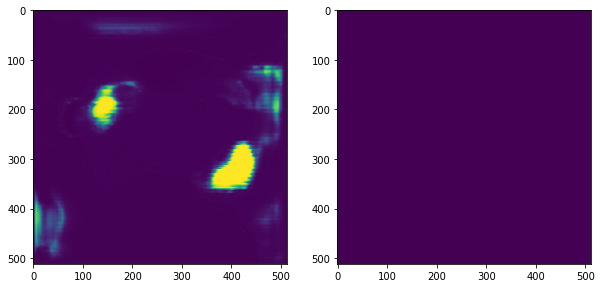

In [204]:
testSample(testDf.sort_values('dice',ascending=True), 2, learner.model)

In [205]:
testDf.dice.describe()

count    1567.000000
mean        0.728389
std         0.313800
min         0.000000
25%         0.548492
50%         0.905524
75%         0.943018
max         0.981197
Name: dice, dtype: float64